In [ ]:
!unzip -q Dataset.zip

In [ ]:
import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import torchvision
from torchsummary import summary

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Question 1 - BMI Estimation

In [ ]:
bmi_data = pd.read_csv("bmi.csv")
bmi_data

Gender  Height  Weight  Index
0      Male     174      96      4
1      Male     189      87      2
2    Female     185     110      4
3    Female     195     104      3
4      Male     149      61      3
..      ...     ...     ...    ...
495  Female     150     153      5
496  Female     184     121      4
497  Female     141     136      5
498    Male     150      95      5
499    Male     173     131      5

[500 rows x 4 columns]

In [ ]:
label_encoder = LabelEncoder()
bmi_data['Gender'] = label_encoder.fit_transform(bmi_data['Gender'])

In [ ]:
bmi_data.shape

(500, 4)

In [ ]:
n_classes = len(pd.unique(bmi_data['Index']))
n_classes

6

In [ ]:
X = torch.from_numpy(bmi_data.to_numpy()[:, :3]).float()
Y = torch.from_numpy(bmi_data.to_numpy()[:, 3]).long()

### Test-train shuffling!

In [ ]:
n_points = X.shape[0]

In [ ]:
torch.manual_seed(0)

In [ ]:
indices = torch.randperm(n_points)

In [ ]:
X_train, y_train, X_test, y_test = X[indices[:int(0.7*n_points)]], Y[indices[:int(0.7*n_points)]], X[indices[int(0.7*n_points):]], Y[indices[int(0.7*n_points):]]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([350, 3]) torch.Size([350]) torch.Size([150, 3]) torch.Size([150])


In [ ]:
n_input_dim = X_train.shape[1]

In [ ]:
class BMIDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
def setup(learning_rate=1e-2, batch_size=32, n_input_dim = 3, n_classes = 6):
    # Loss
    criterion = nn.CrossEntropyLoss()
    # Hyperparameters
    learning_rate = learning_rate
    batch_size = batch_size
    n_epochs = 500
    dataloader_train = DataLoader(BMIDataset(X_train, y_train), batch_size, shuffle=True)
    dataloader_test = DataLoader(BMIDataset(X_test, y_test), batch_size, shuffle=False)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    hidden_dim = 32
    model = nn.Sequential(nn.Linear(n_input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, hidden_dim*2),
                      nn.ReLU(),
                      nn.Linear(hidden_dim*2, n_classes))
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    return model.to(device), criterion, optimizer, n_epochs, device, batch_size, learning_rate, dataloader_train, dataloader_test

In [ ]:
model, criterion, optimizer, n_epochs, device, batch_size, learning_rate, dataloader_train, dataloader_test = setup(1e-2, 32, X_train.shape[1], n_classes)

In [ ]:
def train(dataloader_train, model, criterion, optimizer, n_epochs, device, f_name='best_q1.pt', seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    train_losses, train_accs = [], []
    model.train()
    best_acc = 0
    for epoch in range(n_epochs):
        running_loss, running_acc = 0.0, 0.0
        for data, target in dataloader_train:
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(pred, 1)
            running_loss += loss.item()*data.shape[0]
            running_acc += (predicted == target).sum().item()
        train_losses.append(running_loss/len(dataloader_train.dataset))
        train_accs.append(running_acc/len(dataloader_train.dataset))
        if train_accs[epoch] > best_acc:
            best_acc = train_accs[epoch]
            torch.save(model, f_name)
        if not epoch % int(n_epochs // 10):
            print("Epoch: {} - Loss: {} - Accuracy: {}".format(epoch, train_losses[-1], train_accs[-1]))
    print("Epoch: {} - Loss: {} - Accuracy: {}".format(epoch, train_losses[-1], train_accs[-1]))
    best_model = torch.load(f_name).to(device)
    return best_model, train_losses, train_accs

In [ ]:
best_model, train_losses, train_accs = train(dataloader_train, model, criterion, optimizer, n_epochs, device)

Epoch: 0 - Loss: 12.373818027632577 - Accuracy: 0.38571428571428573
Epoch: 50 - Loss: 0.5931424660342081 - Accuracy: 0.7028571428571428
Epoch: 100 - Loss: 0.6181060118334634 - Accuracy: 0.6828571428571428
Epoch: 150 - Loss: 0.6746650164467948 - Accuracy: 0.6714285714285714
Epoch: 200 - Loss: 0.6376364823750087 - Accuracy: 0.6657142857142857
Epoch: 250 - Loss: 0.5971813566344125 - Accuracy: 0.7028571428571428
Epoch: 300 - Loss: 0.5525526993615286 - Accuracy: 0.72
Epoch: 350 - Loss: 0.5313193385941641 - Accuracy: 0.7428571428571429
Epoch: 400 - Loss: 0.6461034788404192 - Accuracy: 0.7171428571428572
Epoch: 450 - Loss: 0.5520570058482034 - Accuracy: 0.7228571428571429
Epoch: 499 - Loss: 0.5488785093171256 - Accuracy: 0.7228571428571429


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


In [ ]:
def plot(data, plot_type='Train Loss'):
    plt.clf()
    plt.plot(np.arange(len(data)), np.array(data))
    plt.xlabel('Epochs')
    plt.ylabel(plot_type)
    plt.show()

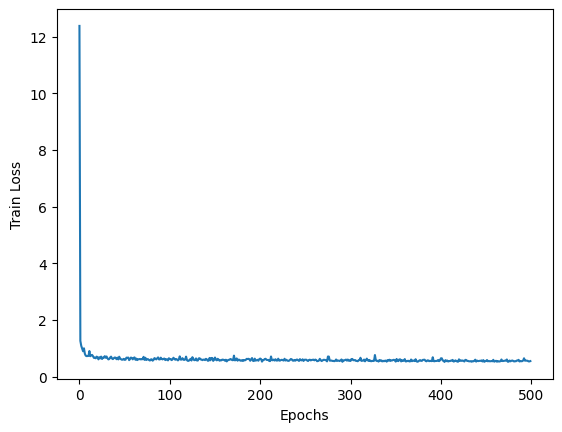

In [ ]:
plot(train_losses, 'Train Loss')

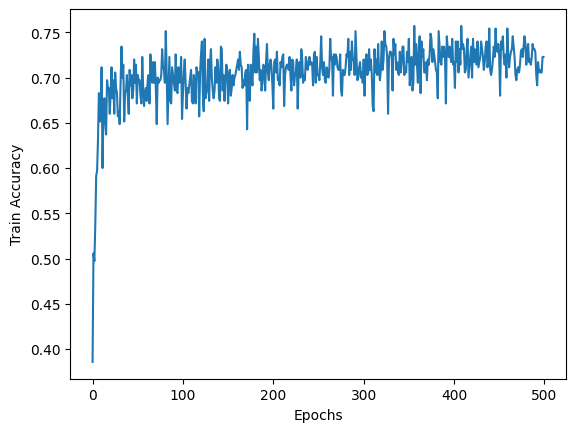

In [ ]:
plot(train_accs, 'Train Accuracy')

In [ ]:
def test(dataloader_test, model, device):
    model.eval()
    with torch.no_grad():
        running_loss, running_acc = 0.0, 0.0
        preds = torch.zeros(0).to(device)
        true = torch.zeros(0).to(device)

        for data, target in dataloader_test:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            loss = criterion(pred, target)

            _, predicted = torch.max(pred, 1)
            running_loss += loss.item()*data.shape[0]
            running_acc += (predicted == target).sum().item()
            preds = torch.cat((preds, predicted), dim=0)
            true = torch.cat((true, target), dim=0)
        print("[TEST] Loss: {} - Accuracy: {}".format(running_loss/len(dataloader_test.dataset), running_acc/len(dataloader_test.dataset)))
        return preds.cpu().numpy(), true.cpu().numpy(), running_acc/len(dataloader_test.dataset)

In [ ]:
y_preds, y_true, _ = test(dataloader_test, best_model, device)

[TEST] Loss: 0.5702285142739614 - Accuracy: 0.7333333333333333


In [ ]:
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 'class 5']

In [ ]:
def print_report(y_preds, y_true, target_names):
    print(classification_report(y_true, y_preds, target_names=target_names))

In [ ]:
print_report(y_preds, y_true, target_names)

              precision    recall  f1-score   support

     class 0       0.67      0.67      0.67         3
     class 1       0.67      0.89      0.76         9
     class 2       0.76      0.76      0.76        25
     class 3       0.57      0.55      0.56        22
     class 4       0.60      0.72      0.66        36
     class 5       0.93      0.78      0.85        55

    accuracy                           0.73       150
   macro avg       0.70      0.73      0.71       150
weighted avg       0.75      0.73      0.74       150



## Grid Search

In [ ]:
lr_possible = [0.1, 0.01, 0.001, 0.0001]
batch_size_possible = [8, 16, 32, 64]

In [ ]:
results = {}

lr_0.1_bs_8.pt
Epoch: 0 - Loss: 136.62501317705426 - Accuracy: 0.38
Epoch: 50 - Loss: 1.4835654864992414 - Accuracy: 0.4085714285714286
Epoch: 100 - Loss: 1.4817332424436296 - Accuracy: 0.4085714285714286
Epoch: 150 - Loss: 1.475164281981332 - Accuracy: 0.4085714285714286
Epoch: 200 - Loss: 1.4760823856081282 - Accuracy: 0.4085714285714286
Epoch: 250 - Loss: 1.475646491391318 - Accuracy: 0.4085714285714286
Epoch: 300 - Loss: 1.4754885605403356 - Accuracy: 0.4085714285714286
Epoch: 350 - Loss: 1.473544031551906 - Accuracy: 0.4085714285714286
Epoch: 400 - Loss: 1.4738006496429443 - Accuracy: 0.4085714285714286
Epoch: 450 - Loss: 1.4748507956096104 - Accuracy: 0.4085714285714286
Epoch: 499 - Loss: 1.47376467023577 - Accuracy: 0.4085714285714286


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


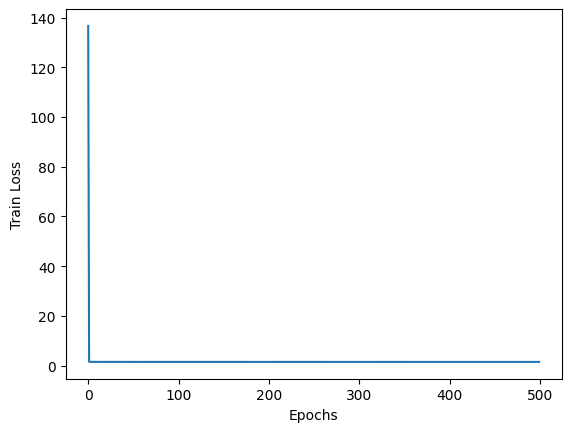

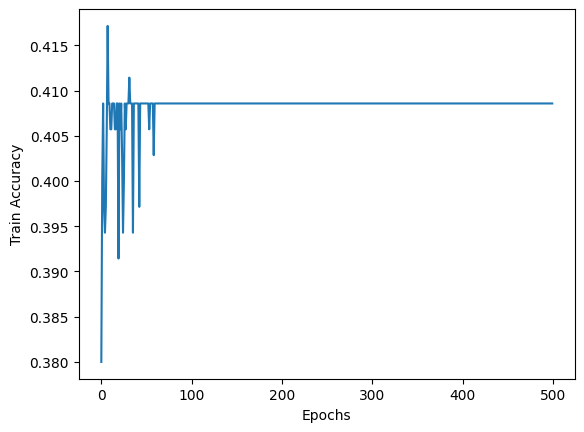

[TEST] Loss: 1.5512616554896037 - Accuracy: 0.36666666666666664
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.00      0.00      0.00         9
     class 2       0.00      0.00      0.00        25
     class 3       0.00      0.00      0.00        22
     class 4       0.00      0.00      0.00        36
     class 5       0.37      1.00      0.54        55

    accuracy                           0.37       150
   macro avg       0.06      0.17      0.09       150
weighted avg       0.13      0.37      0.20       150

lr_0.1_bs_16.pt
Epoch: 0 - Loss: 85.72045452458518 - Accuracy: 0.35428571428571426


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50 - Loss: 1.477321537562779 - Accuracy: 0.4085714285714286
Epoch: 100 - Loss: 1.4781532737186978 - Accuracy: 0.4085714285714286
Epoch: 150 - Loss: 1.4738507734026227 - Accuracy: 0.4085714285714286
Epoch: 200 - Loss: 1.4752450507027761 - Accuracy: 0.4085714285714286
Epoch: 250 - Loss: 1.4764480870110648 - Accuracy: 0.4085714285714286
Epoch: 300 - Loss: 1.4757137966156006 - Accuracy: 0.4085714285714286
Epoch: 350 - Loss: 1.474209566116333 - Accuracy: 0.4085714285714286
Epoch: 400 - Loss: 1.4720532158442905 - Accuracy: 0.4085714285714286
Epoch: 450 - Loss: 1.4773553671155657 - Accuracy: 0.4085714285714286
Epoch: 499 - Loss: 1.4735794843946184 - Accuracy: 0.4085714285714286


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


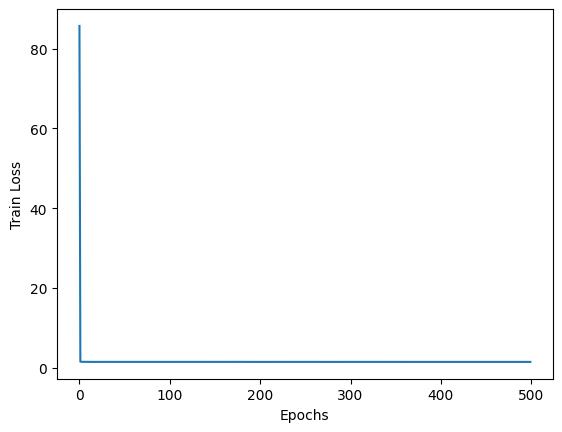

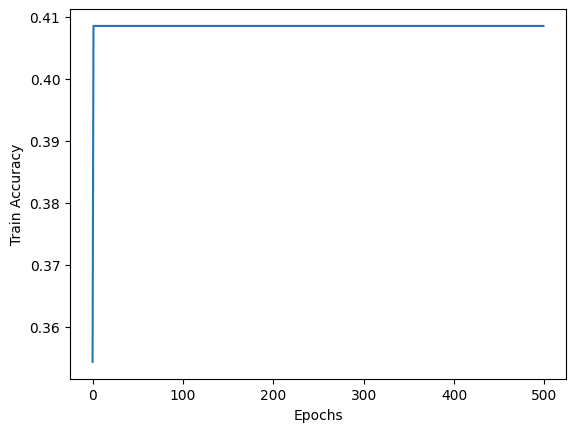

[TEST] Loss: 1.6230885457992554 - Accuracy: 0.36666666666666664
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.00      0.00      0.00         9
     class 2       0.00      0.00      0.00        25
     class 3       0.00      0.00      0.00        22
     class 4       0.00      0.00      0.00        36
     class 5       0.37      1.00      0.54        55

    accuracy                           0.37       150
   macro avg       0.06      0.17      0.09       150
weighted avg       0.13      0.37      0.20       150

lr_0.1_bs_32.pt
Epoch: 0 - Loss: 50.33034390313285 - Accuracy: 0.3657142857142857


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50 - Loss: 1.4741386338642666 - Accuracy: 0.4085714285714286
Epoch: 100 - Loss: 1.4736342321123395 - Accuracy: 0.4085714285714286
Epoch: 150 - Loss: 1.4733396809441703 - Accuracy: 0.4085714285714286
Epoch: 200 - Loss: 1.4734657614571707 - Accuracy: 0.4085714285714286
Epoch: 250 - Loss: 1.475548735346113 - Accuracy: 0.4085714285714286
Epoch: 300 - Loss: 1.4733154433114188 - Accuracy: 0.4085714285714286
Epoch: 350 - Loss: 1.4755925294331143 - Accuracy: 0.4085714285714286
Epoch: 400 - Loss: 1.473960908481053 - Accuracy: 0.4085714285714286
Epoch: 450 - Loss: 1.473545023373195 - Accuracy: 0.4085714285714286
Epoch: 499 - Loss: 1.4739122779028757 - Accuracy: 0.4085714285714286


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


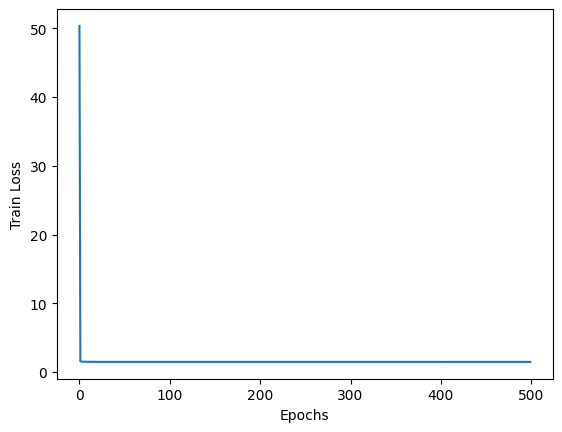

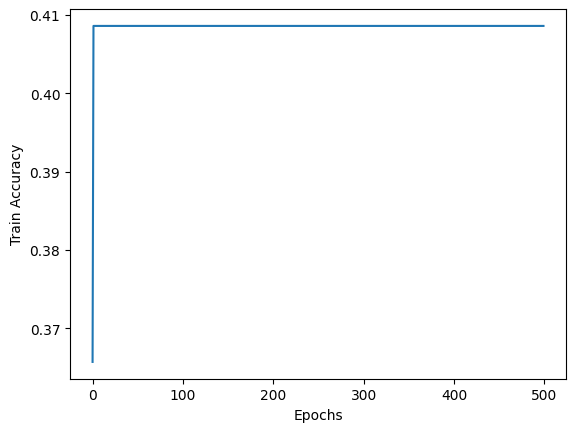

[TEST] Loss: 1.6402288993199667 - Accuracy: 0.36666666666666664
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.00      0.00      0.00         9
     class 2       0.00      0.00      0.00        25
     class 3       0.00      0.00      0.00        22
     class 4       0.00      0.00      0.00        36
     class 5       0.37      1.00      0.54        55

    accuracy                           0.37       150
   macro avg       0.06      0.17      0.09       150
weighted avg       0.13      0.37      0.20       150

lr_0.1_bs_64.pt
Epoch: 0 - Loss: 244.14439007895334 - Accuracy: 0.30857142857142855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50 - Loss: 1.4726995277404784 - Accuracy: 0.4085714285714286
Epoch: 100 - Loss: 1.4718514394760132 - Accuracy: 0.4085714285714286
Epoch: 150 - Loss: 1.4750354848589216 - Accuracy: 0.4085714285714286
Epoch: 200 - Loss: 1.471546288899013 - Accuracy: 0.4085714285714286
Epoch: 250 - Loss: 1.4709336369378225 - Accuracy: 0.4085714285714286
Epoch: 300 - Loss: 1.4706254529953002 - Accuracy: 0.4085714285714286
Epoch: 350 - Loss: 1.4750727707999094 - Accuracy: 0.4085714285714286
Epoch: 400 - Loss: 1.4727677215848651 - Accuracy: 0.4085714285714286
Epoch: 450 - Loss: 1.4715497943333218 - Accuracy: 0.4085714285714286
Epoch: 499 - Loss: 1.4716003697259086 - Accuracy: 0.4085714285714286


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


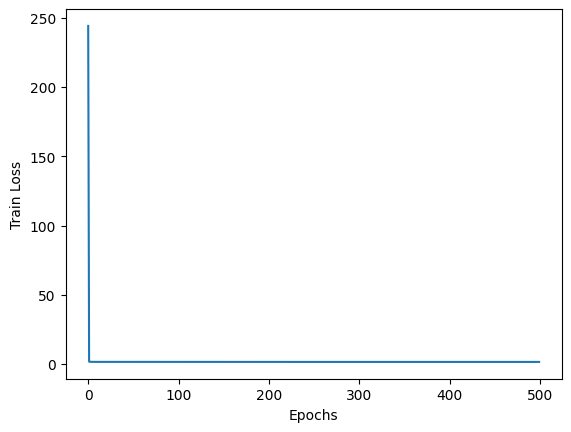

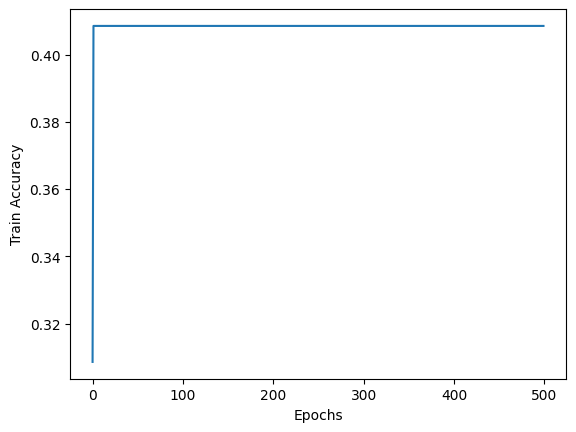

[TEST] Loss: 1.644202734629313 - Accuracy: 0.36666666666666664
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.00      0.00      0.00         9
     class 2       0.00      0.00      0.00        25
     class 3       0.00      0.00      0.00        22
     class 4       0.00      0.00      0.00        36
     class 5       0.37      1.00      0.54        55

    accuracy                           0.37       150
   macro avg       0.06      0.17      0.09       150
weighted avg       0.13      0.37      0.20       150

lr_0.01_bs_8.pt
Epoch: 0 - Loss: 3.386310041291373 - Accuracy: 0.46


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50 - Loss: 0.6729560989141464 - Accuracy: 0.6428571428571429
Epoch: 100 - Loss: 0.6524750007901873 - Accuracy: 0.6485714285714286
Epoch: 150 - Loss: 0.6284544546263559 - Accuracy: 0.6885714285714286
Epoch: 200 - Loss: 0.6422559927191053 - Accuracy: 0.7
Epoch: 250 - Loss: 0.6481880375317165 - Accuracy: 0.7342857142857143
Epoch: 300 - Loss: 0.5886201735905239 - Accuracy: 0.7028571428571428
Epoch: 350 - Loss: 0.5896092443806784 - Accuracy: 0.72
Epoch: 400 - Loss: 0.5627241006919316 - Accuracy: 0.7142857142857143
Epoch: 450 - Loss: 0.5610499043124063 - Accuracy: 0.7285714285714285
Epoch: 499 - Loss: 0.5674368606294904 - Accuracy: 0.7142857142857143


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


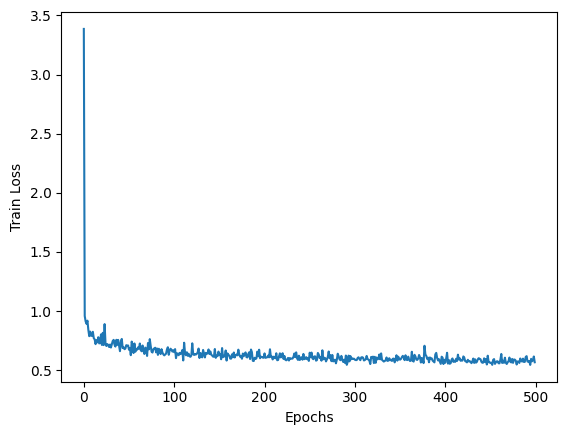

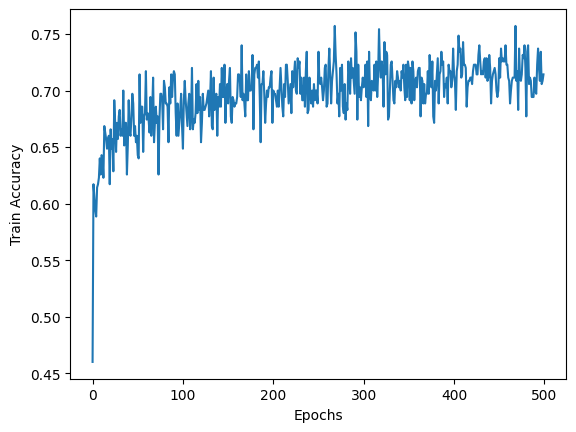

[TEST] Loss: 0.6463666852315267 - Accuracy: 0.7133333333333334
              precision    recall  f1-score   support

     class 0       0.25      0.67      0.36         3
     class 1       0.67      0.22      0.33         9
     class 2       0.76      0.88      0.81        25
     class 3       0.57      0.55      0.56        22
     class 4       0.60      0.72      0.66        36
     class 5       0.93      0.78      0.85        55

    accuracy                           0.71       150
   macro avg       0.63      0.64      0.60       150
weighted avg       0.74      0.71      0.72       150

lr_0.01_bs_16.pt
Epoch: 0 - Loss: 6.145287429945809 - Accuracy: 0.4
Epoch: 50 - Loss: 0.6316455720152174 - Accuracy: 0.6771428571428572
Epoch: 100 - Loss: 0.6483294124262674 - Accuracy: 0.6828571428571428
Epoch: 150 - Loss: 0.6544714668818883 - Accuracy: 0.6742857142857143
Epoch: 200 - Loss: 0.6172767116342273 - Accuracy: 0.7285714285714285
Epoch: 250 - Loss: 0.592926697731018 - Accuracy: 0.

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


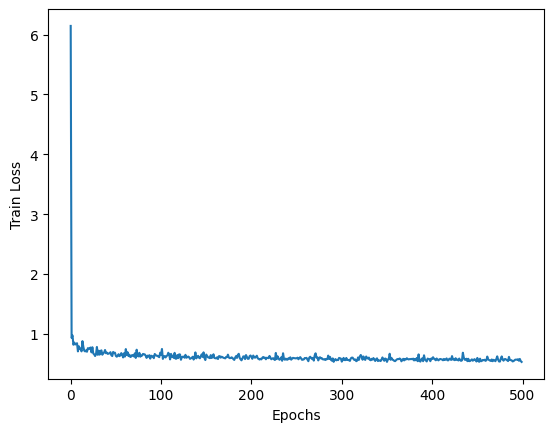

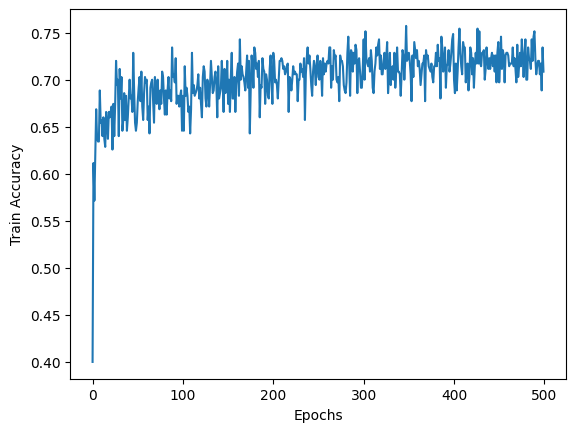

[TEST] Loss: 0.6184071417649587 - Accuracy: 0.74
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.54      0.78      0.64         9
     class 2       0.93      0.52      0.67        25
     class 3       0.60      0.68      0.64        22
     class 4       0.64      0.78      0.70        36
     class 5       0.92      0.84      0.88        55

    accuracy                           0.74       150
   macro avg       0.69      0.71      0.68       150
weighted avg       0.78      0.74      0.74       150

lr_0.01_bs_32.pt
Epoch: 0 - Loss: 9.439207630838666 - Accuracy: 0.36857142857142855
Epoch: 50 - Loss: 0.5822334168638502 - Accuracy: 0.7057142857142857
Epoch: 100 - Loss: 0.6394771240438734 - Accuracy: 0.68
Epoch: 150 - Loss: 0.6646003355298723 - Accuracy: 0.6828571428571428
Epoch: 200 - Loss: 0.6404117751121521 - Accuracy: 0.6542857142857142
Epoch: 250 - Loss: 0.6041094980921065 - Accuracy: 0.7
Epoch: 30

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


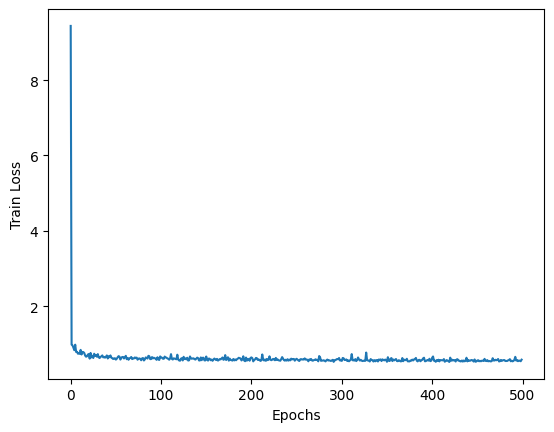

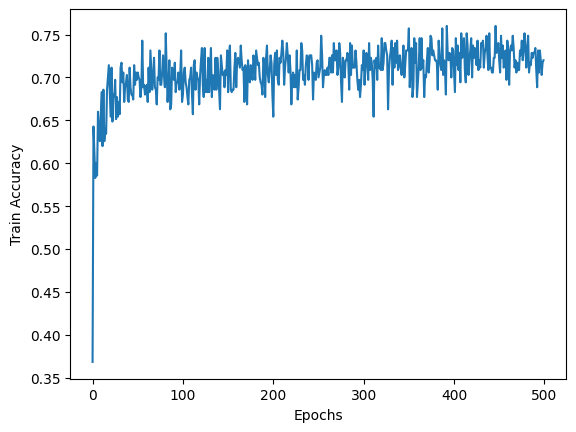

[TEST] Loss: 0.5882890061537425 - Accuracy: 0.7733333333333333
              precision    recall  f1-score   support

     class 0       0.67      0.67      0.67         3
     class 1       0.80      0.89      0.84         9
     class 2       0.78      0.84      0.81        25
     class 3       0.62      0.68      0.65        22
     class 4       0.67      0.72      0.69        36
     class 5       0.94      0.80      0.86        55

    accuracy                           0.77       150
   macro avg       0.75      0.77      0.75       150
weighted avg       0.79      0.77      0.78       150

lr_0.01_bs_64.pt
Epoch: 0 - Loss: 16.17716206959316 - Accuracy: 0.21428571428571427
Epoch: 50 - Loss: 0.6701866517748152 - Accuracy: 0.6857142857142857
Epoch: 100 - Loss: 0.6763967984063285 - Accuracy: 0.6714285714285714
Epoch: 150 - Loss: 0.6053100684710911 - Accuracy: 0.7228571428571429
Epoch: 200 - Loss: 0.5996081621306283 - Accuracy: 0.6914285714285714
Epoch: 250 - Loss: 0.56639995881489

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


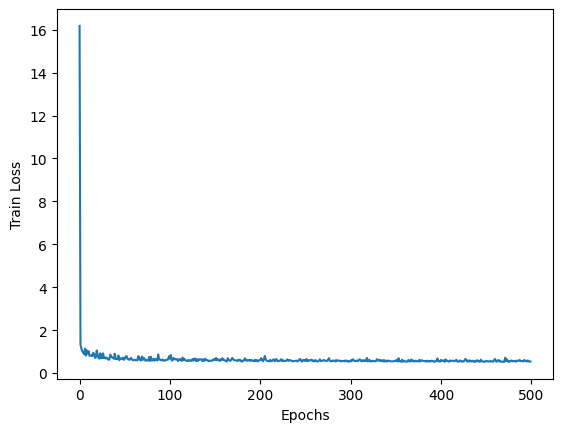

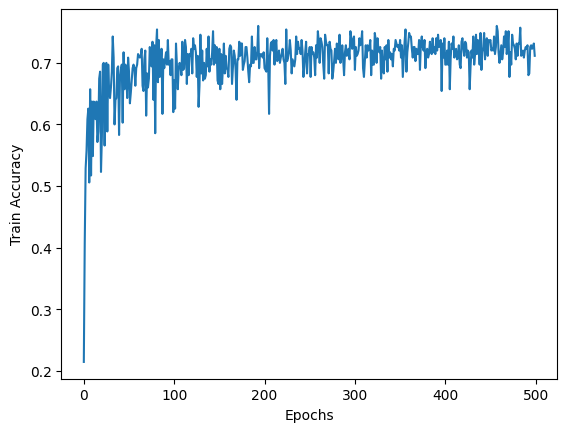

[TEST] Loss: 0.6072306994597118 - Accuracy: 0.7533333333333333
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       1.00      0.33      0.50         9
     class 2       0.74      0.92      0.82        25
     class 3       0.67      0.55      0.60        22
     class 4       0.62      0.81      0.70        36
     class 5       0.94      0.80      0.86        55

    accuracy                           0.75       150
   macro avg       0.74      0.68      0.68       150
weighted avg       0.78      0.75      0.75       150

lr_0.001_bs_8.pt
Epoch: 0 - Loss: 3.3585558809552873 - Accuracy: 0.4228571428571429
Epoch: 50 - Loss: 0.606035207935742 - Accuracy: 0.6914285714285714
Epoch: 100 - Loss: 0.5896661095108304 - Accuracy: 0.7142857142857143
Epoch: 150 - Loss: 0.5622547946657453 - Accuracy: 0.7171428571428572
Epoch: 200 - Loss: 0.5761372329507555 - Accuracy: 0.7142857142857143
Epoch: 250 - Loss: 0.562587233952113

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


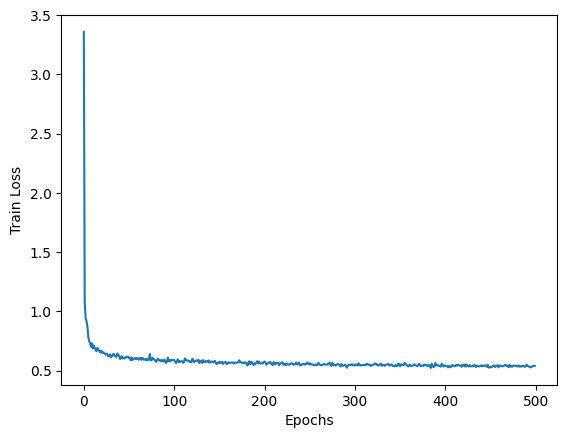

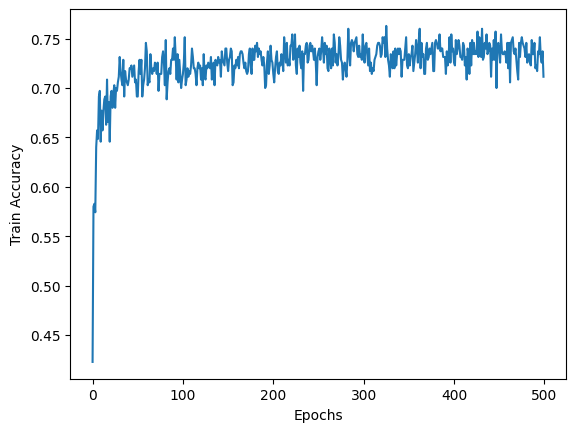

[TEST] Loss: 0.6248068253199259 - Accuracy: 0.7133333333333334
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.54      0.78      0.64         9
     class 2       0.69      0.72      0.71        25
     class 3       0.56      0.45      0.50        22
     class 4       0.66      0.64      0.65        36
     class 5       0.87      0.85      0.86        55

    accuracy                           0.71       150
   macro avg       0.64      0.69      0.65       150
weighted avg       0.72      0.71      0.71       150

lr_0.001_bs_16.pt
Epoch: 0 - Loss: 4.245397261892046 - Accuracy: 0.37142857142857144
Epoch: 50 - Loss: 0.6106095210143498 - Accuracy: 0.7085714285714285
Epoch: 100 - Loss: 0.6029597352232252 - Accuracy: 0.7114285714285714
Epoch: 150 - Loss: 0.6008213332721165 - Accuracy: 0.7142857142857143
Epoch: 200 - Loss: 0.5792812182222093 - Accuracy: 0.7314285714285714
Epoch: 250 - Loss: 0.5956206161635

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


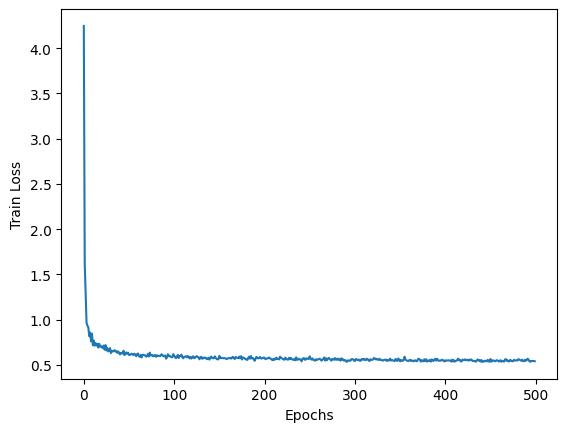

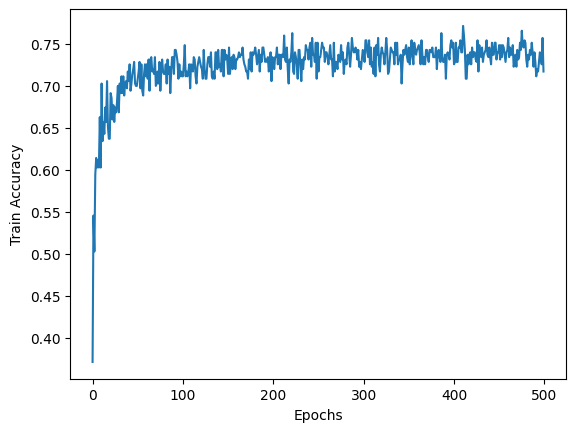

[TEST] Loss: 0.6182340244452159 - Accuracy: 0.72
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.54      0.78      0.64         9
     class 2       0.72      0.72      0.72        25
     class 3       0.58      0.50      0.54        22
     class 4       0.66      0.64      0.65        36
     class 5       0.87      0.85      0.86        55

    accuracy                           0.72       150
   macro avg       0.64      0.69      0.66       150
weighted avg       0.72      0.72      0.72       150

lr_0.001_bs_32.pt
Epoch: 0 - Loss: 5.5789434398923605 - Accuracy: 0.37142857142857144
Epoch: 50 - Loss: 0.6466208260399955 - Accuracy: 0.6942857142857143
Epoch: 100 - Loss: 0.5960234303133828 - Accuracy: 0.7
Epoch: 150 - Loss: 0.6254261394909449 - Accuracy: 0.72
Epoch: 200 - Loss: 0.5919256493023464 - Accuracy: 0.7228571428571429
Epoch: 250 - Loss: 0.5792322329112461 - Accuracy: 0.7514285714285714
Epoch: 

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


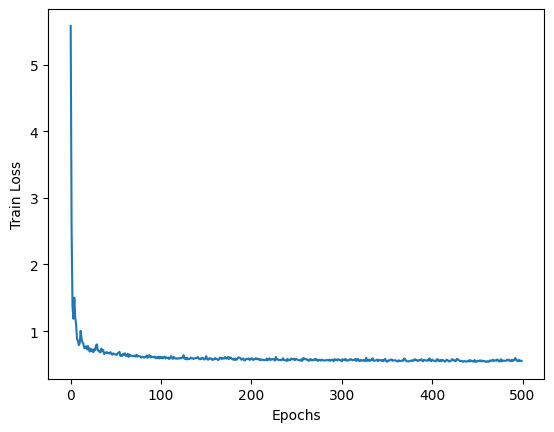

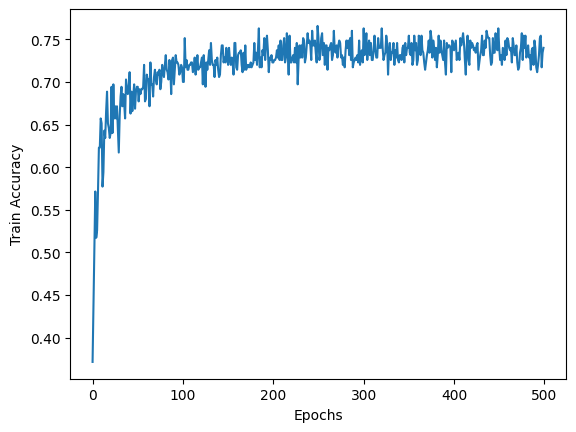

[TEST] Loss: 0.6226295681794485 - Accuracy: 0.6933333333333334
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.64      0.78      0.70         9
     class 2       0.61      0.80      0.69        25
     class 3       0.43      0.27      0.33        22
     class 4       0.66      0.64      0.65        36
     class 5       0.87      0.84      0.85        55

    accuracy                           0.69       150
   macro avg       0.62      0.67      0.63       150
weighted avg       0.69      0.69      0.69       150

lr_0.001_bs_64.pt
Epoch: 0 - Loss: 6.491120414733887 - Accuracy: 0.23142857142857143
Epoch: 50 - Loss: 0.696575699874333 - Accuracy: 0.6857142857142857
Epoch: 100 - Loss: 0.6295567209380014 - Accuracy: 0.6914285714285714
Epoch: 150 - Loss: 0.6232982080323356 - Accuracy: 0.7171428571428572
Epoch: 200 - Loss: 0.6021956767354693 - Accuracy: 0.7057142857142857
Epoch: 250 - Loss: 0.57784511872700

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


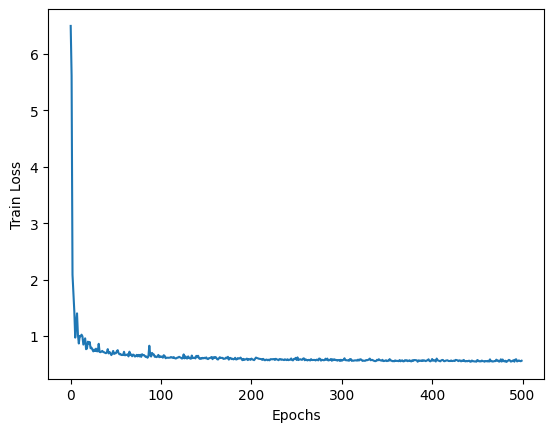

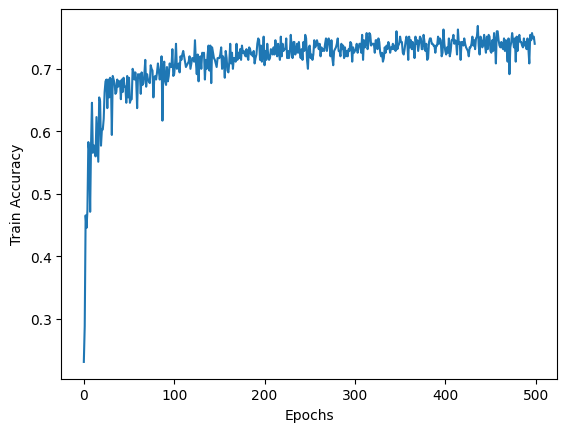

[TEST] Loss: 0.6331068968772888 - Accuracy: 0.6866666666666666
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       0.80      0.44      0.57         9
     class 2       0.59      0.92      0.72        25
     class 3       0.38      0.14      0.20        22
     class 4       0.59      0.83      0.69        36
     class 5       0.95      0.75      0.84        55

    accuracy                           0.69       150
   macro avg       0.63      0.62      0.60       150
weighted avg       0.70      0.69      0.67       150

lr_0.0001_bs_8.pt
Epoch: 0 - Loss: 1.9011305366243636 - Accuracy: 0.4657142857142857
Epoch: 50 - Loss: 0.7114725705555507 - Accuracy: 0.6657142857142857
Epoch: 100 - Loss: 0.6702850382668631 - Accuracy: 0.6857142857142857
Epoch: 150 - Loss: 0.6251762526375907 - Accuracy: 0.7057142857142857
Epoch: 200 - Loss: 0.6171676811150142 - Accuracy: 0.6971428571428572
Epoch: 250 - Loss: 0.6022758136476

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


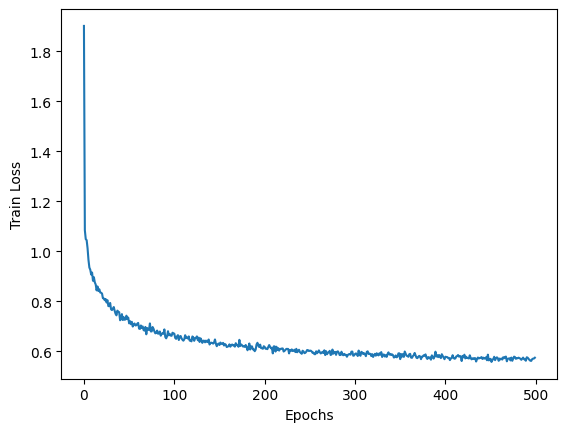

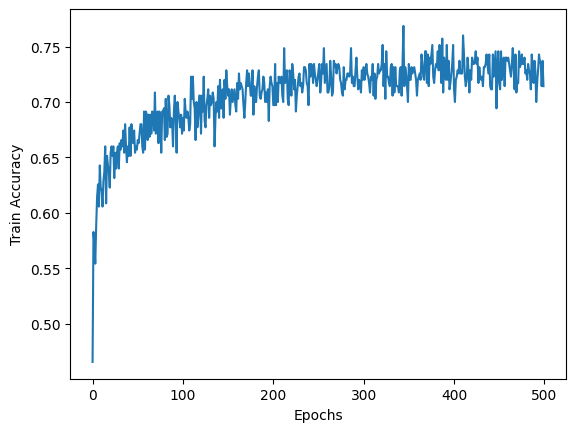

[TEST] Loss: 0.6337657248973847 - Accuracy: 0.7066666666666667
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       1.00      0.11      0.20         9
     class 2       0.63      0.96      0.76        25
     class 3       0.67      0.27      0.39        22
     class 4       0.58      0.89      0.70        36
     class 5       0.95      0.75      0.84        55

    accuracy                           0.71       150
   macro avg       0.72      0.61      0.58       150
weighted avg       0.76      0.71      0.68       150

lr_0.0001_bs_16.pt
Epoch: 0 - Loss: 2.5736193084716796 - Accuracy: 0.4057142857142857
Epoch: 50 - Loss: 0.7771805235317775 - Accuracy: 0.6657142857142857
Epoch: 100 - Loss: 0.7092573060308184 - Accuracy: 0.6742857142857143
Epoch: 150 - Loss: 0.6767465996742249 - Accuracy: 0.6885714285714286
Epoch: 200 - Loss: 0.648573898928506 - Accuracy: 0.6971428571428572
Epoch: 250 - Loss: 0.6390559840202

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


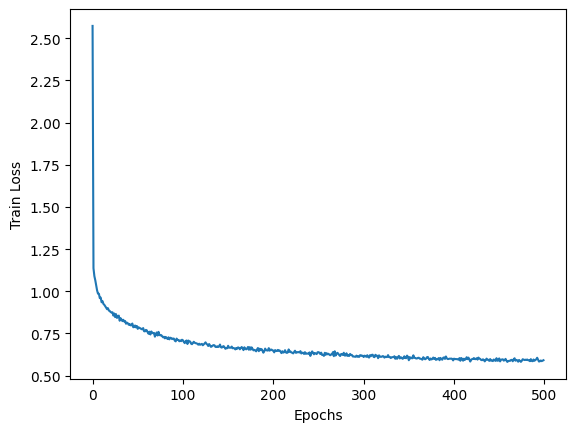

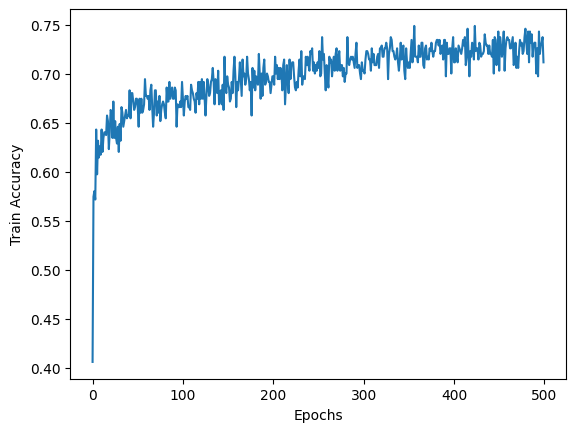

[TEST] Loss: 0.6397855559984843 - Accuracy: 0.7266666666666667
              precision    recall  f1-score   support

     class 0       0.50      0.67      0.57         3
     class 1       1.00      0.33      0.50         9
     class 2       0.70      0.92      0.79        25
     class 3       0.57      0.55      0.56        22
     class 4       0.60      0.72      0.66        36
     class 5       0.93      0.78      0.85        55

    accuracy                           0.73       150
   macro avg       0.72      0.66      0.66       150
weighted avg       0.76      0.73      0.73       150

lr_0.0001_bs_32.pt
Epoch: 0 - Loss: 3.863298200879778 - Accuracy: 0.26857142857142857
Epoch: 50 - Loss: 0.8400204801559448 - Accuracy: 0.6485714285714286
Epoch: 100 - Loss: 0.7672338203021458 - Accuracy: 0.6685714285714286
Epoch: 150 - Loss: 0.7387152412959508 - Accuracy: 0.68
Epoch: 200 - Loss: 0.7026351724352156 - Accuracy: 0.6685714285714286
Epoch: 250 - Loss: 0.6788526630401611 - Accurac

<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


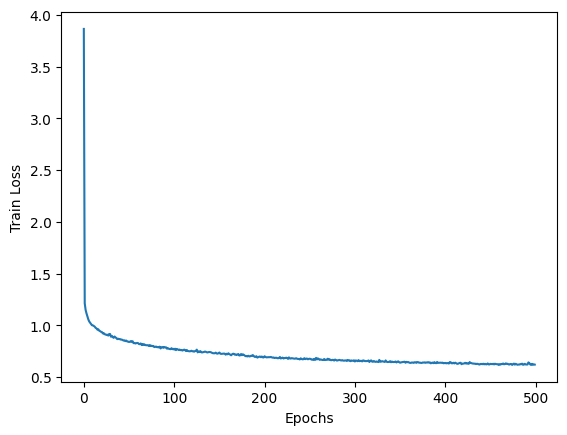

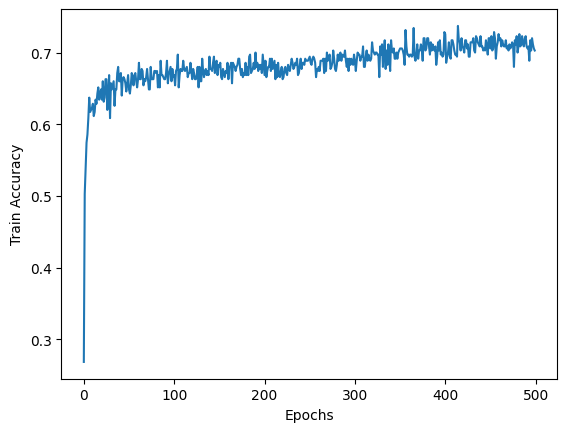

[TEST] Loss: 0.6681989264488221 - Accuracy: 0.7133333333333334
              precision    recall  f1-score   support

     class 0       1.00      0.67      0.80         3
     class 1       0.00      0.00      0.00         9
     class 2       0.61      0.92      0.73        25
     class 3       0.57      0.55      0.56        22
     class 4       0.62      0.72      0.67        36
     class 5       0.94      0.80      0.86        55

    accuracy                           0.71       150
   macro avg       0.62      0.61      0.60       150
weighted avg       0.70      0.71      0.70       150

lr_0.0001_bs_64.pt
Epoch: 0 - Loss: 6.3057619449070526 - Accuracy: 0.10285714285714286


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50 - Loss: 0.90054295028959 - Accuracy: 0.6628571428571428
Epoch: 100 - Loss: 0.8277802106312343 - Accuracy: 0.6714285714285714
Epoch: 150 - Loss: 0.7908689171927316 - Accuracy: 0.6742857142857143
Epoch: 200 - Loss: 0.7620651139531817 - Accuracy: 0.6685714285714286
Epoch: 250 - Loss: 0.7367398704801287 - Accuracy: 0.6771428571428572
Epoch: 300 - Loss: 0.7172018694877624 - Accuracy: 0.6742857142857143
Epoch: 350 - Loss: 0.7009269567898342 - Accuracy: 0.6828571428571428
Epoch: 400 - Loss: 0.6866845791680473 - Accuracy: 0.68
Epoch: 450 - Loss: 0.67394773040499 - Accuracy: 0.6857142857142857
Epoch: 499 - Loss: 0.6633573961257935 - Accuracy: 0.6914285714285714


<ipython-input-18-c3bf03568657>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


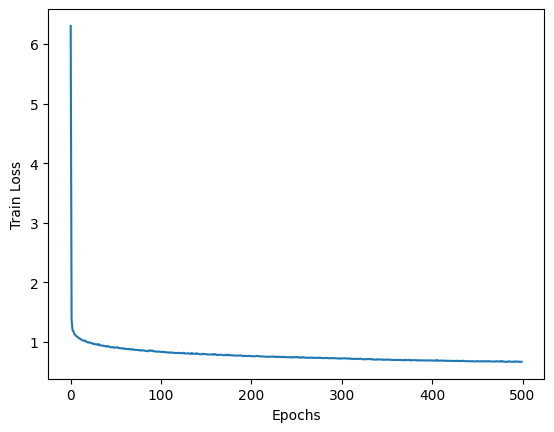

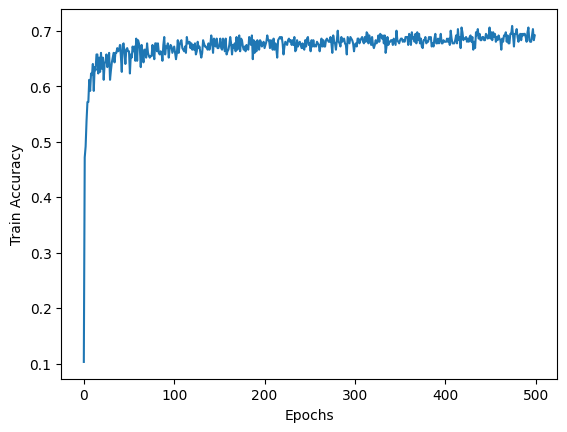

[TEST] Loss: 0.7084271144866944 - Accuracy: 0.6933333333333334
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.00      0.00      0.00         9
     class 2       0.61      0.92      0.73        25
     class 3       0.57      0.55      0.56        22
     class 4       0.64      0.64      0.64        36
     class 5       0.87      0.84      0.85        55

    accuracy                           0.69       150
   macro avg       0.45      0.49      0.46       150
weighted avg       0.66      0.69      0.67       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 'class 5']
for learning_rate in lr_possible:
    for batch_size in batch_size_possible:
        f_name = 'lr_{}_bs_{}.pt'.format(learning_rate, batch_size)
        print(f_name)
        model, criterion, optimizer, n_epochs, device, _, _, dataloader_train, dataloader_test = setup(learning_rate, batch_size, X_train.shape[1], n_classes)
        best_model, train_losses, train_accs = train(dataloader_train, model, criterion, optimizer, n_epochs, device, f_name)
        plot(train_losses, 'Train Loss')
        plot(train_accs, 'Train Accuracy')
        y_preds, y_true, test_acc = test(dataloader_test, best_model, device)
        results[f_name] = test_acc
        print_report(y_preds, y_true, target_names)

In [ ]:
results

{'lr_0.1_bs_8.pt': 0.36666666666666664,
 'lr_0.1_bs_16.pt': 0.36666666666666664,
 'lr_0.1_bs_32.pt': 0.36666666666666664,
 'lr_0.1_bs_64.pt': 0.36666666666666664,
 'lr_0.01_bs_8.pt': 0.7133333333333334,
 'lr_0.01_bs_16.pt': 0.74,
 'lr_0.01_bs_32.pt': 0.7733333333333333,
 'lr_0.01_bs_64.pt': 0.7533333333333333,
 'lr_0.001_bs_8.pt': 0.7133333333333334,
 'lr_0.001_bs_16.pt': 0.72,
 'lr_0.001_bs_32.pt': 0.6933333333333334,
 'lr_0.001_bs_64.pt': 0.6866666666666666,
 'lr_0.0001_bs_8.pt': 0.7066666666666667,
 'lr_0.0001_bs_16.pt': 0.7266666666666667,
 'lr_0.0001_bs_32.pt': 0.7133333333333334,
 'lr_0.0001_bs_64.pt': 0.6933333333333334}

In [ ]:
sorted(results.items(), key=lambda x: x[1], reverse=True)

[('lr_0.01_bs_32.pt', 0.7733333333333333),
 ('lr_0.01_bs_64.pt', 0.7533333333333333),
 ('lr_0.01_bs_16.pt', 0.74),
 ('lr_0.0001_bs_16.pt', 0.7266666666666667),
 ('lr_0.001_bs_16.pt', 0.72),
 ('lr_0.01_bs_8.pt', 0.7133333333333334),
 ('lr_0.001_bs_8.pt', 0.7133333333333334),
 ('lr_0.0001_bs_32.pt', 0.7133333333333334),
 ('lr_0.0001_bs_8.pt', 0.7066666666666667),
 ('lr_0.001_bs_32.pt', 0.6933333333333334),
 ('lr_0.0001_bs_64.pt', 0.6933333333333334),
 ('lr_0.001_bs_64.pt', 0.6866666666666666),
 ('lr_0.1_bs_8.pt', 0.36666666666666664),
 ('lr_0.1_bs_16.pt', 0.36666666666666664),
 ('lr_0.1_bs_32.pt', 0.36666666666666664),
 ('lr_0.1_bs_64.pt', 0.36666666666666664)]

In [ ]:
best_config = sorted(results.items(), key=lambda x: x[1], reverse=True)[0]
configs, acc = best_config

In [ ]:
print("Best accuracy: {}, config is with Learning Rate of: {} and Batch Size of: {}".format(acc, configs.split('_')[1], configs.split('_')[3].split('.')[0]))

Best accuracy: 0.7733333333333333, config is with Learning Rate of: 0.01 and Batch Size of: 32


## Question 2 - Concrete Strength

In [ ]:
concrete_data = pd.read_csv("concrete_data.csv")
concrete_data

Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0      540.0                 0.0      0.0  162.0               2.5   
1      540.0                 0.0      0.0  162.0               2.5   
2      332.5               142.5      0.0  228.0               0.0   
3      332.5               142.5      0.0  228.0               0.0   
4      198.6               132.4      0.0  192.0               0.0   
...      ...                 ...      ...    ...               ...   
1025   276.4               116.0     90.3  179.6               8.9   
1026   322.2                 0.0    115.6  196.0              10.4   
1027   148.5               139.4    108.6  192.7               6.1   
1028   159.1               186.7      0.0  175.6              11.3   
1029   260.9               100.5     78.3  200.6               8.6   

      Coarse Aggregate  Fine Aggregate  Age  Strength  
0               1040.0           676.0   28     79.99  
1               1055.0           676.0   28     61.89  
2                932.0           594.0  270     40.27  
3                932.0           594.0  365     41.05  
4                978.4           825.5  360     44.30  
...                ...             ...  ...       ...  
1025             870.1           768.3   28     44.28  
1026             817.9           813.4   28     31.18  
1027             892.4           780.0   28     23.70  
1028             989.6           788.9   28     32.77  
1029             864.5           761.5   28     32.40  

[1030 rows x 9 columns]

In [ ]:
X = torch.from_numpy(concrete_data.to_numpy()[:, :-1]).float()
Y = torch.from_numpy(concrete_data.to_numpy()[:, -1]).float()

In [ ]:
for i in range(X.shape[1]):
    X[:, i] /= X[:, i].max()

In [ ]:
X.shape

torch.Size([1030, 8])

In [ ]:
torch.manual_seed(0)

In [ ]:
n_points = X.shape[0]

In [ ]:
indices = torch.randperm(n_points)

In [ ]:
X_train, y_train, X_test, y_test = X[indices[:int(0.7*n_points)]], Y[indices[:int(0.7*n_points)]], X[indices[int(0.7*n_points):]], Y[indices[int(0.7*n_points):]]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([721, 8]) torch.Size([721]) torch.Size([309, 8]) torch.Size([309])


In [ ]:
class ConcreteDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
def setup(learning_rate=1e-2, batch_size=32, n_input_dim = 3, loss_type='mse'):
    # Loss
    if loss_type == 'mse':
        criterion = nn.MSELoss()
    elif loss_type == 'mae':
        criterion = nn.L1Loss()
    # Hyperparameters
    learning_rate = learning_rate
    batch_size = batch_size
    n_epochs = 500
    dataloader_train = DataLoader(ConcreteDataset(X_train, y_train), batch_size, shuffle=True)
    dataloader_test = DataLoader(ConcreteDataset(X_test, y_test), batch_size, shuffle=False)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    hidden_dim = 32
    model = nn.Sequential(nn.Linear(n_input_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, hidden_dim*2),
                      nn.ReLU(),
                      nn.Linear(hidden_dim*2, 1))
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    return model.to(device), criterion, optimizer, n_epochs, device, batch_size, learning_rate, dataloader_train, dataloader_test

In [ ]:
model, criterion, optimizer, n_epochs, device, batch_size, learning_rate, dataloader_train, dataloader_test = setup(1e-2, 32, X_train.shape[1], 'mae')

In [ ]:
model

Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
def train(dataloader_train, model, criterion, optimizer, n_epochs, device, f_name='best_q2.pt', seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    train_losses = []
    model.train()
    best_loss = 0
    for epoch in range(n_epochs):
        running_loss, running_acc = 0.0, 0.0
        for data, target in dataloader_train:
            data = data.to(device)
            target = target.to(device).unsqueeze(1)

            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*data.shape[0]
        train_losses.append(running_loss/len(dataloader_train.dataset))
        if train_losses[epoch] > best_loss:
            best_loss = train_losses[epoch]
            torch.save(model, f_name)
        if not epoch % int(n_epochs // 10):
            print("Epoch: {} - Loss: {}".format(epoch, train_losses[-1]))
    print("Epoch: {} - Loss: {} ".format(epoch, train_losses[-1]))
    best_model = torch.load(f_name).to(device)
    return best_model, train_losses

In [ ]:
best_model, train_losses = train(dataloader_train, model, criterion, optimizer, n_epochs, device)

Epoch: 0 - Loss: 36.346051421145624
Epoch: 50 - Loss: 8.205728147297725
Epoch: 100 - Loss: 7.066944569390624
Epoch: 150 - Loss: 6.970129706161859
Epoch: 200 - Loss: 6.0644935953137615
Epoch: 250 - Loss: 5.741899869313022
Epoch: 300 - Loss: 5.144746608443135
Epoch: 350 - Loss: 5.2348629141978185
Epoch: 400 - Loss: 5.230768919983122
Epoch: 450 - Loss: 5.10558785281135
Epoch: 499 - Loss: 5.093426284446134 


<ipython-input-48-c0f2cad45098>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


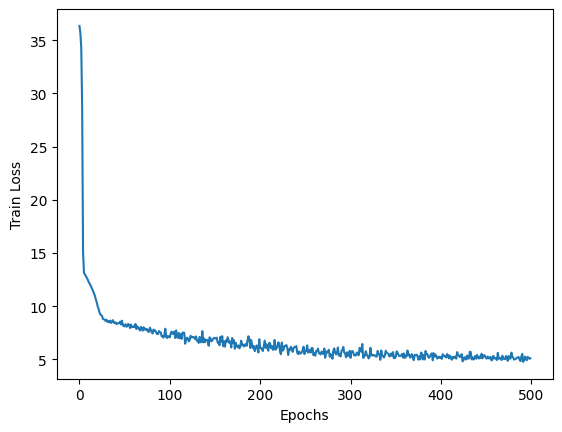

In [ ]:
plot(train_losses, 'Train Loss')

In [ ]:
def test(dataloader_test, model, device):
    model.eval()
    with torch.no_grad():
        running_loss_mse, running_loss_mae = 0.0, 0.0

        for data, target in dataloader_test:
            data = data.to(device)
            target = target.to(device).unsqueeze(1)
            pred = model(data)
            loss_mse = torch.nn.functional.mse_loss(pred, target)
            loss_mae = torch.nn.functional.l1_loss(pred, target)
            running_loss_mse += loss_mse.item()*data.shape[0]
            running_loss_mae += loss_mae.item()*data.shape[0]


        print("[TEST] MSE Loss: {} - MAE Loss: {}".format(running_loss_mse/len(dataloader_test.dataset), running_loss_mae/len(dataloader_test.dataset)))
        return running_loss_mse/len(dataloader_test.dataset), running_loss_mae/len(dataloader_test.dataset)

In [ ]:
mse_loss, mae_loss = test(dataloader_test, best_model, device)

[TEST] MSE Loss: 1377.3129863060021 - MAE Loss: 33.491792524516775


In [ ]:
lr_possible = [0.01, 0.001, 0.0001]
batch_size_possible = [8, 16, 32, 64]
loss_possible = ['mse', 'mae']

In [ ]:
results_regression_mse = {}
results_regression_mae = {}

loss_mse_lr_0.01_bs_8.pt
Epoch: 0 - Loss: 489.8239667981078
Epoch: 50 - Loss: 287.21218698530686
Epoch: 100 - Loss: 287.60224112459093
Epoch: 150 - Loss: 287.4327408067066
Epoch: 200 - Loss: 287.3182502143426
Epoch: 250 - Loss: 287.3292631501133
Epoch: 300 - Loss: 287.2865233001365
Epoch: 350 - Loss: 287.32726018008844
Epoch: 400 - Loss: 287.20471953287534
Epoch: 450 - Loss: 287.47983130932516
Epoch: 499 - Loss: 287.4018335051411 


<ipython-input-48-c0f2cad45098>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f_name).to(device)


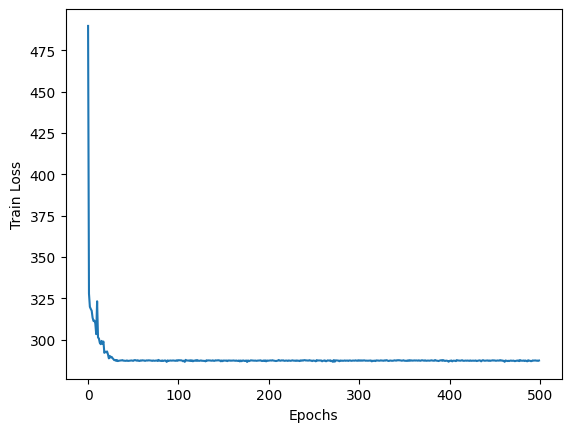

[TEST] MSE Loss: 265.8385728755815 - MAE Loss: 13.359984712693297
loss_mse_lr_0.01_bs_16.pt
Epoch: 0 - Loss: 1475.758141463408
Epoch: 50 - Loss: 287.0287162368076
Epoch: 100 - Loss: 287.2030266326608
Epoch: 150 - Loss: 287.06441124467676
Epoch: 200 - Loss: 287.1130976366104
Epoch: 250 - Loss: 287.0734836787357
Epoch: 300 - Loss: 287.00390547720633
Epoch: 350 - Loss: 287.1427476012591
Epoch: 400 - Loss: 287.0410522799551
Epoch: 450 - Loss: 287.32171529275206
Epoch: 499 - Loss: 287.6864945921587 


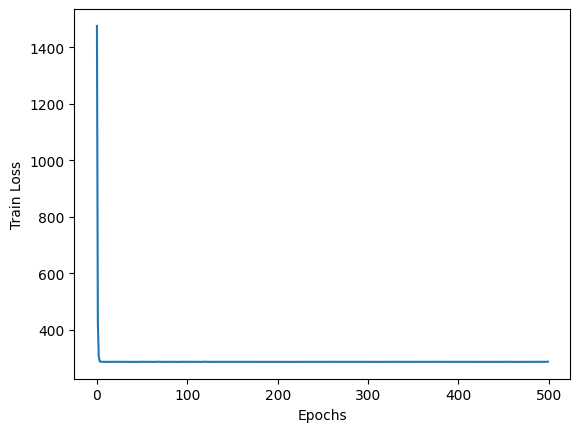

[TEST] MSE Loss: 468.16851293076206 - MAE Loss: 17.199369955217183
loss_mse_lr_0.01_bs_32.pt
Epoch: 0 - Loss: 1616.6364019766925
Epoch: 50 - Loss: 292.4380762785384
Epoch: 100 - Loss: 294.6451388079978
Epoch: 150 - Loss: 290.1783964498364
Epoch: 200 - Loss: 289.1008236867876
Epoch: 250 - Loss: 289.41395003785703
Epoch: 300 - Loss: 287.0645249111477
Epoch: 350 - Loss: 288.01708984375
Epoch: 400 - Loss: 287.333599497971
Epoch: 450 - Loss: 287.38219004299043
Epoch: 499 - Loss: 287.0557113626298 


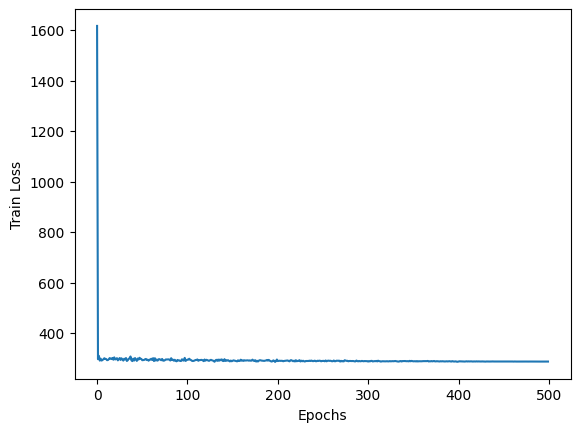

[TEST] MSE Loss: 256.0693616651023 - MAE Loss: 12.900786464654127
loss_mse_lr_0.01_bs_64.pt
Epoch: 0 - Loss: 3571.0442162036234
Epoch: 50 - Loss: 286.85787849584995
Epoch: 100 - Loss: 286.87762895602623
Epoch: 150 - Loss: 286.7899045587082
Epoch: 200 - Loss: 286.82420076113635
Epoch: 250 - Loss: 286.82241469977134
Epoch: 300 - Loss: 286.8576586507726
Epoch: 350 - Loss: 286.85678680462246
Epoch: 400 - Loss: 286.8156819548587
Epoch: 450 - Loss: 286.8640388139574
Epoch: 499 - Loss: 286.92786179964486 


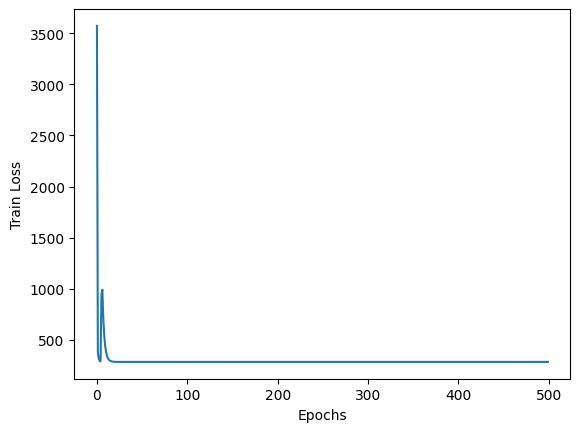

[TEST] MSE Loss: 868.1357978894872 - MAE Loss: 24.941899475542087
loss_mse_lr_0.001_bs_8.pt
Epoch: 0 - Loss: 418.368788289131
Epoch: 50 - Loss: 72.37357079999292
Epoch: 100 - Loss: 77.80042614540842
Epoch: 150 - Loss: 56.31199232252229
Epoch: 200 - Loss: 56.08056374495634
Epoch: 250 - Loss: 50.98848927004493
Epoch: 300 - Loss: 49.49630571172241
Epoch: 350 - Loss: 41.676340343882735
Epoch: 400 - Loss: 38.82849057438304
Epoch: 450 - Loss: 52.75977721326725
Epoch: 499 - Loss: 49.952594968052416 


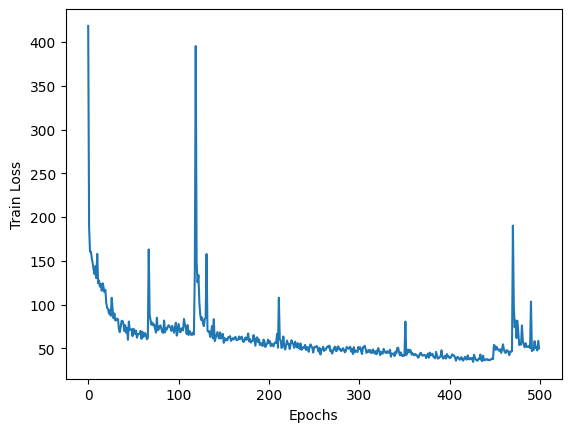

[TEST] MSE Loss: 175.17641713164 - MAE Loss: 10.906386881584488
loss_mse_lr_0.001_bs_16.pt
Epoch: 0 - Loss: 591.9386576204128
Epoch: 50 - Loss: 102.12971544860967
Epoch: 100 - Loss: 79.99468594682035
Epoch: 150 - Loss: 63.62318573844582
Epoch: 200 - Loss: 64.35779424447789
Epoch: 250 - Loss: 52.66260137571211
Epoch: 300 - Loss: 53.13308829044337
Epoch: 350 - Loss: 48.74981147670878
Epoch: 400 - Loss: 54.35687648307599
Epoch: 450 - Loss: 44.32019209233468
Epoch: 499 - Loss: 48.18184827646336 


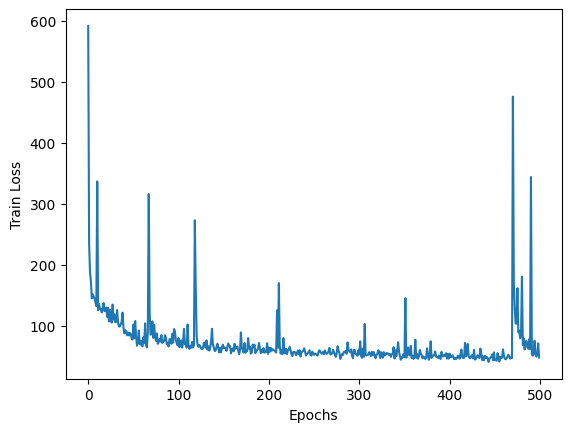

[TEST] MSE Loss: 218.1507198988041 - MAE Loss: 12.140855468206807
loss_mse_lr_0.001_bs_32.pt
Epoch: 0 - Loss: 940.1294050706077
Epoch: 50 - Loss: 105.43307466546639
Epoch: 100 - Loss: 89.9745532920721
Epoch: 150 - Loss: 74.29420625154916
Epoch: 200 - Loss: 46.55266428721265
Epoch: 250 - Loss: 44.09472044099551
Epoch: 300 - Loss: 43.38997060217573
Epoch: 350 - Loss: 40.539288995666084
Epoch: 400 - Loss: 42.199424278058224
Epoch: 450 - Loss: 39.196591666931916
Epoch: 499 - Loss: 38.94572589599144 


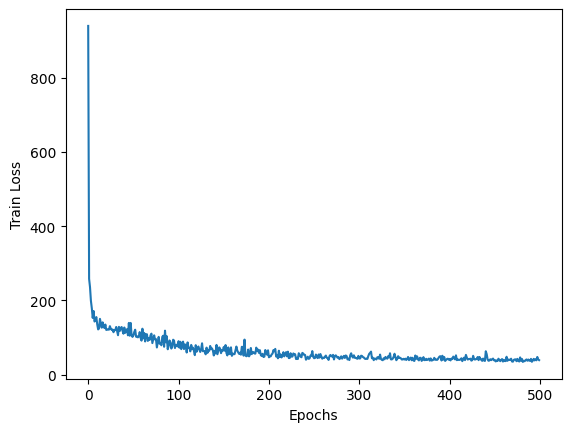

[TEST] MSE Loss: 239.945344252108 - MAE Loss: 12.720192412342454
loss_mse_lr_0.001_bs_64.pt
Epoch: 0 - Loss: 1492.4669888690837
Epoch: 50 - Loss: 118.37133279025306
Epoch: 100 - Loss: 89.82596541575354
Epoch: 150 - Loss: 96.40532139898504
Epoch: 200 - Loss: 73.62565626020074
Epoch: 250 - Loss: 50.92742774952797
Epoch: 300 - Loss: 75.42906090026094
Epoch: 350 - Loss: 47.18399817140026
Epoch: 400 - Loss: 49.441494982715454
Epoch: 450 - Loss: 51.89214609598485
Epoch: 499 - Loss: 45.552408676041644 


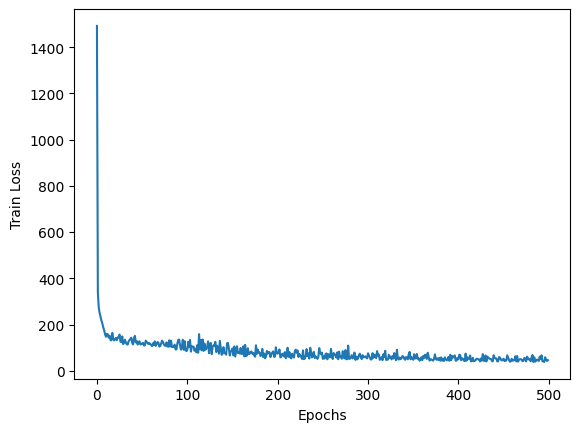

[TEST] MSE Loss: 648.3202767480153 - MAE Loss: 20.787793211952383
loss_mse_lr_0.0001_bs_8.pt
Epoch: 0 - Loss: 1522.7632999922796
Epoch: 50 - Loss: 111.09563405305437
Epoch: 100 - Loss: 87.05898202440589
Epoch: 150 - Loss: 56.22245525090275
Epoch: 200 - Loss: 49.68379988385966
Epoch: 250 - Loss: 44.9930255641223
Epoch: 300 - Loss: 43.15848090480006
Epoch: 350 - Loss: 43.67192984487081
Epoch: 400 - Loss: 42.49607834042193
Epoch: 450 - Loss: 39.772338230219695
Epoch: 499 - Loss: 39.21188369372681 


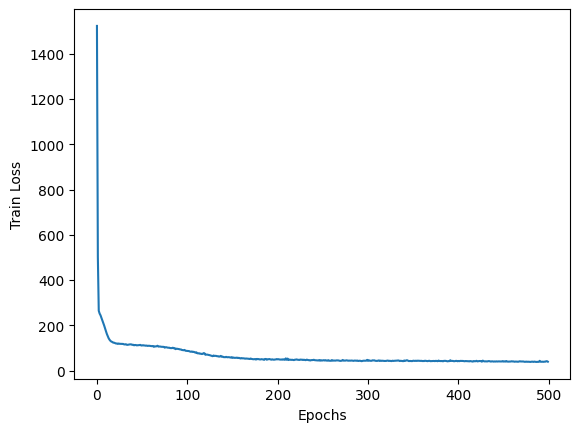

[TEST] MSE Loss: 1049.5158126485387 - MAE Loss: 28.25336783449241
loss_mse_lr_0.0001_bs_16.pt
Epoch: 0 - Loss: 1601.8886778007434
Epoch: 50 - Loss: 116.88695496229788
Epoch: 100 - Loss: 109.42926029623298
Epoch: 150 - Loss: 101.1391110982379
Epoch: 200 - Loss: 83.5943945859573
Epoch: 250 - Loss: 63.923513859551754
Epoch: 300 - Loss: 55.68506127091618
Epoch: 350 - Loss: 48.885483163735735
Epoch: 400 - Loss: 46.20464229087724
Epoch: 450 - Loss: 43.911852287684006
Epoch: 499 - Loss: 43.20512316668414 


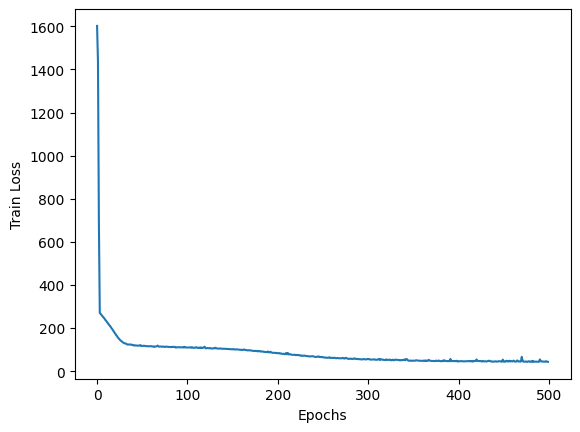

[TEST] MSE Loss: 1343.1011326860842 - MAE Loss: 32.97841054181836
loss_mse_lr_0.0001_bs_32.pt
Epoch: 0 - Loss: 1624.1426670111498
Epoch: 50 - Loss: 147.33427655647267
Epoch: 100 - Loss: 116.42214994390861
Epoch: 150 - Loss: 111.90820374931938
Epoch: 200 - Loss: 108.77719965920204
Epoch: 250 - Loss: 104.36120839323978
Epoch: 300 - Loss: 99.68290549607615
Epoch: 350 - Loss: 91.45402364426612
Epoch: 400 - Loss: 80.16054912678247
Epoch: 450 - Loss: 70.04670262965018
Epoch: 499 - Loss: 62.01868111217568 


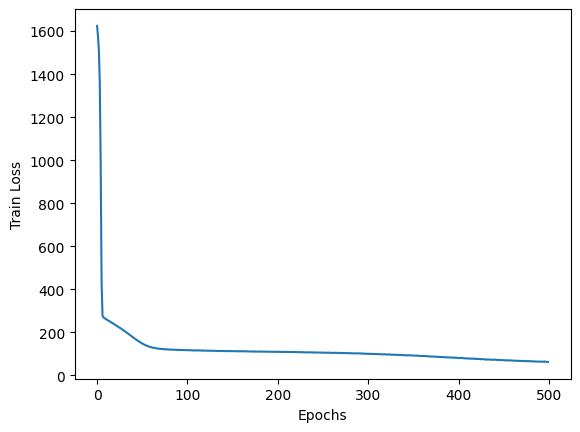

[TEST] MSE Loss: 1392.1120324983565 - MAE Loss: 33.71065991596111
loss_mse_lr_0.0001_bs_64.pt
Epoch: 0 - Loss: 1634.469216779267
Epoch: 50 - Loss: 218.5202398842482
Epoch: 100 - Loss: 143.01607637233442
Epoch: 150 - Loss: 119.89119077092566
Epoch: 200 - Loss: 115.69736999215432
Epoch: 250 - Loss: 112.72079730199214
Epoch: 300 - Loss: 110.89021694908195
Epoch: 350 - Loss: 109.70512308657749
Epoch: 400 - Loss: 107.91638070369726
Epoch: 450 - Loss: 106.49353046390782
Epoch: 499 - Loss: 104.00615875201814 


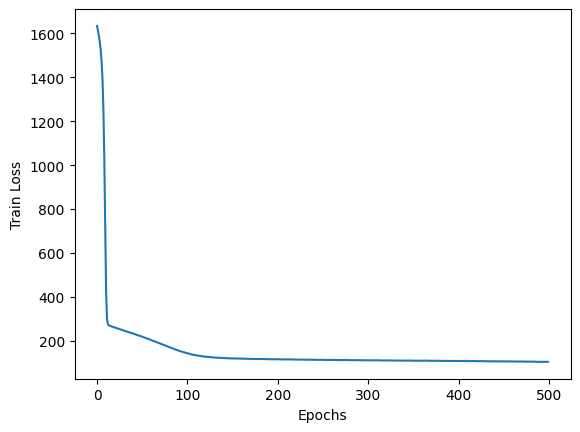

[TEST] MSE Loss: 1411.0067004355026 - MAE Loss: 33.98877292620711
loss_mae_lr_0.01_bs_8.pt
Epoch: 0 - Loss: 31.629055089328887
Epoch: 50 - Loss: 7.066181119371221
Epoch: 100 - Loss: 5.522970834486031
Epoch: 150 - Loss: 5.02450039317307
Epoch: 200 - Loss: 5.200925272810641
Epoch: 250 - Loss: 4.794547932819255
Epoch: 300 - Loss: 4.768816954550565
Epoch: 350 - Loss: 4.769397463117327
Epoch: 400 - Loss: 4.655665466424992
Epoch: 450 - Loss: 4.6270518402120775
Epoch: 499 - Loss: 4.395307579252161 


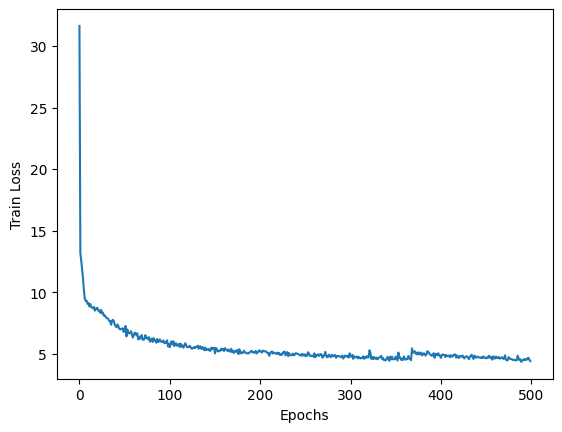

[TEST] MSE Loss: 247.2655927046989 - MAE Loss: 12.863503298713166
loss_mae_lr_0.01_bs_16.pt
Epoch: 0 - Loss: 35.981967873116965
Epoch: 50 - Loss: 7.931925388711831
Epoch: 100 - Loss: 6.426429917842109
Epoch: 150 - Loss: 5.784772854406857
Epoch: 200 - Loss: 5.591361396355702
Epoch: 250 - Loss: 5.19222796012889
Epoch: 300 - Loss: 5.101451990177827
Epoch: 350 - Loss: 4.822836480425069
Epoch: 400 - Loss: 5.432295935494559
Epoch: 450 - Loss: 5.250431829285853
Epoch: 499 - Loss: 5.007972706703471 


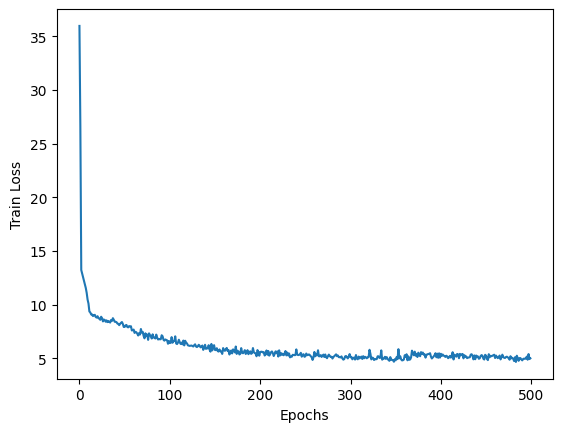

[TEST] MSE Loss: 1281.9611942822107 - MAE Loss: 32.04037048438606
loss_mae_lr_0.01_bs_32.pt
Epoch: 0 - Loss: 36.470100170034975
Epoch: 50 - Loss: 8.432372124945736
Epoch: 100 - Loss: 7.856125485053836
Epoch: 150 - Loss: 7.158252295442494
Epoch: 200 - Loss: 5.953261368152338
Epoch: 250 - Loss: 5.818257528270664
Epoch: 300 - Loss: 5.470875055548553
Epoch: 350 - Loss: 5.2869364504344585
Epoch: 400 - Loss: 5.371764802734333
Epoch: 450 - Loss: 5.418830099119062
Epoch: 499 - Loss: 5.04963263460072 


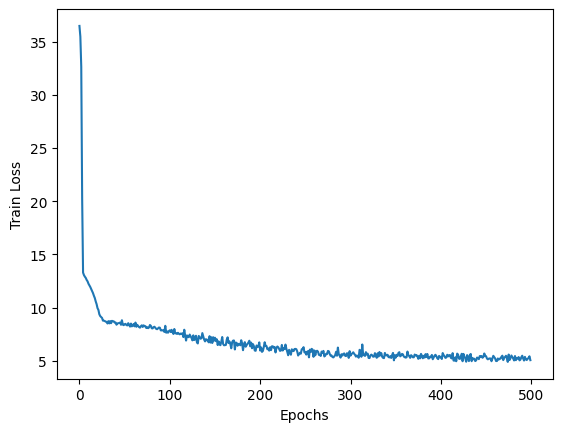

[TEST] MSE Loss: 1376.4972935154985 - MAE Loss: 33.478704977189835
loss_mae_lr_0.01_bs_64.pt
Epoch: 0 - Loss: 36.66489499815625
Epoch: 50 - Loss: 8.732540225850395
Epoch: 100 - Loss: 8.368091349793538
Epoch: 150 - Loss: 8.021560703335787
Epoch: 200 - Loss: 7.955623840326741
Epoch: 250 - Loss: 6.9454380907066655
Epoch: 300 - Loss: 6.090188759209875
Epoch: 350 - Loss: 6.1606989647578265
Epoch: 400 - Loss: 5.991177396866882
Epoch: 450 - Loss: 5.701005085166053
Epoch: 499 - Loss: 5.947684803882022 


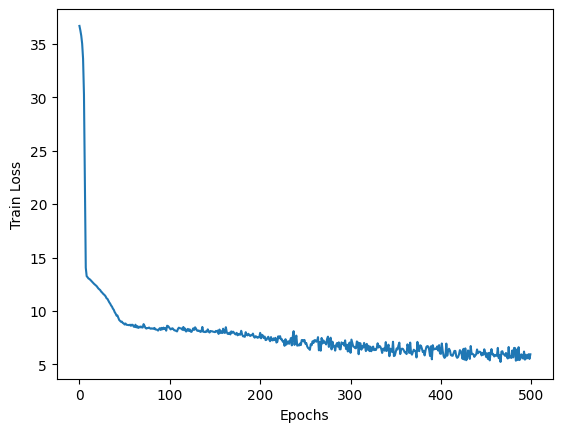

[TEST] MSE Loss: 1403.7638061918487 - MAE Loss: 33.88223565357789
loss_mae_lr_0.001_bs_8.pt
Epoch: 0 - Loss: 36.688059120336945
Epoch: 50 - Loss: 9.994098139536694
Epoch: 100 - Loss: 8.332711295182099
Epoch: 150 - Loss: 8.10667424724436
Epoch: 200 - Loss: 7.870916766035739
Epoch: 250 - Loss: 7.340909844132634
Epoch: 300 - Loss: 6.492575906020758
Epoch: 350 - Loss: 5.792840785689228
Epoch: 400 - Loss: 5.465916751327197
Epoch: 450 - Loss: 5.158304580868365
Epoch: 499 - Loss: 4.904946548102137 


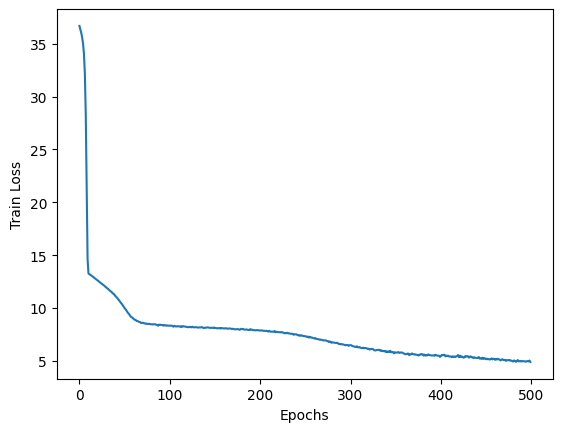

[TEST] MSE Loss: 1410.4350566185021 - MAE Loss: 33.980236164574485
loss_mae_lr_0.001_bs_16.pt
Epoch: 0 - Loss: 36.76469373769138
Epoch: 50 - Loss: 12.256759532447001
Epoch: 100 - Loss: 10.00651642353624
Epoch: 150 - Loss: 8.504850279110975
Epoch: 200 - Loss: 8.296208525828284
Epoch: 250 - Loss: 8.141287998088355
Epoch: 300 - Loss: 8.090792234000155
Epoch: 350 - Loss: 8.0013012403258
Epoch: 400 - Loss: 7.840366001102696
Epoch: 450 - Loss: 7.603289326417793
Epoch: 499 - Loss: 7.284387493265816 


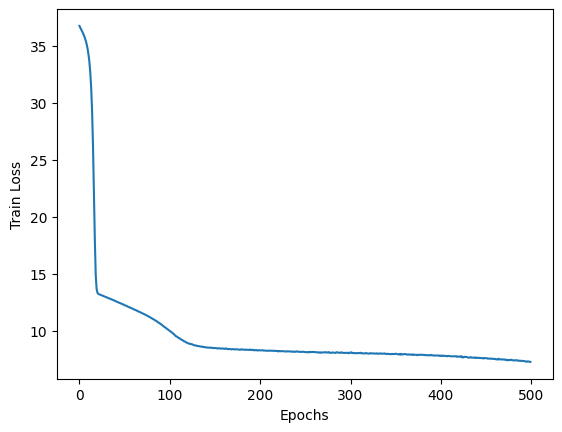

[TEST] MSE Loss: 1420.8042173910296 - MAE Loss: 34.132029709306735
loss_mae_lr_0.001_bs_32.pt
Epoch: 0 - Loss: 36.803376471616026
Epoch: 50 - Loss: 13.109898777510686
Epoch: 100 - Loss: 12.25972791452183
Epoch: 150 - Loss: 11.320096781118236
Epoch: 200 - Loss: 9.93488037040594
Epoch: 250 - Loss: 8.771801287192082
Epoch: 300 - Loss: 8.470854449702037
Epoch: 350 - Loss: 8.36265367277783
Epoch: 400 - Loss: 8.273440913254609
Epoch: 450 - Loss: 8.189887627483902
Epoch: 499 - Loss: 8.141295735283798 


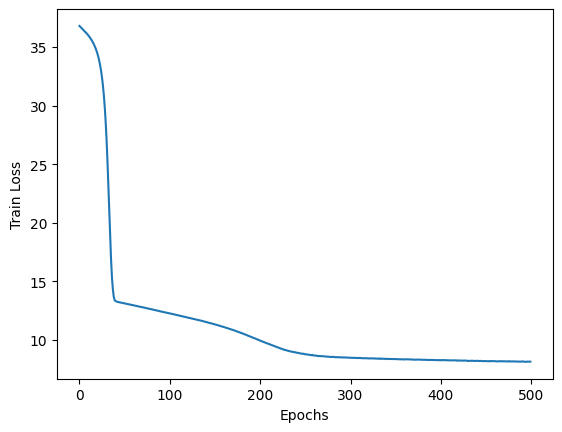

[TEST] MSE Loss: 1426.1611276768558 - MAE Loss: 34.21019472041948
loss_mae_lr_0.001_bs_64.pt
Epoch: 0 - Loss: 36.822904774616894
Epoch: 50 - Loss: 31.82463111295449
Epoch: 100 - Loss: 13.080490904608315
Epoch: 150 - Loss: 12.634554711525714
Epoch: 200 - Loss: 12.180224152775313
Epoch: 250 - Loss: 11.717331060920111
Epoch: 300 - Loss: 11.175731764752392
Epoch: 350 - Loss: 10.488626839879812
Epoch: 400 - Loss: 9.675139071375916
Epoch: 450 - Loss: 8.990782755588526
Epoch: 499 - Loss: 8.67236295321778 


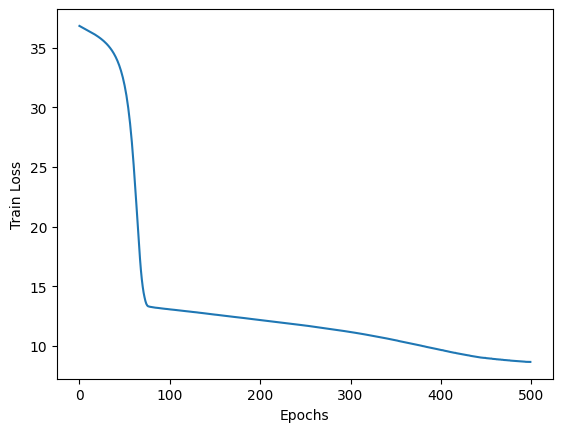

[TEST] MSE Loss: 1428.755751131422 - MAE Loss: 34.248000197426016
loss_mae_lr_0.0001_bs_8.pt
Epoch: 0 - Loss: 36.82529245765464
Epoch: 50 - Loss: 34.52859796531984
Epoch: 100 - Loss: 13.338396784005978
Epoch: 150 - Loss: 12.957614861645744
Epoch: 200 - Loss: 12.618693800144486
Epoch: 250 - Loss: 12.275036635908108
Epoch: 300 - Loss: 11.92455939876223
Epoch: 350 - Loss: 11.559615117997634
Epoch: 400 - Loss: 11.128531867356637
Epoch: 450 - Loss: 10.613837612485423
Epoch: 499 - Loss: 10.019296900078592 


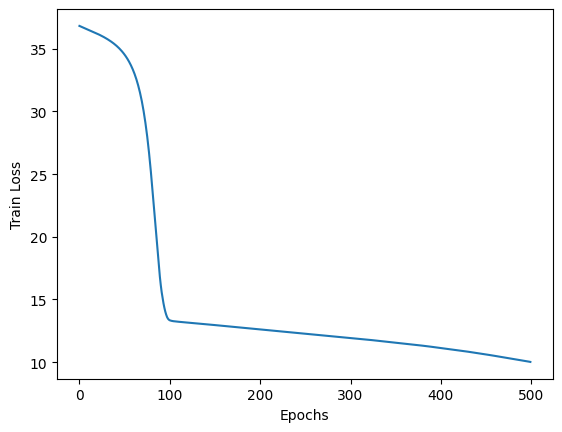

[TEST] MSE Loss: 1429.4448921672736 - MAE Loss: 34.25803234507737
loss_mae_lr_0.0001_bs_16.pt
Epoch: 0 - Loss: 36.833157072450845
Epoch: 50 - Loss: 36.01195453109424
Epoch: 100 - Loss: 34.49860154573861
Epoch: 150 - Loss: 27.647365985399475
Epoch: 200 - Loss: 13.319503903223639
Epoch: 250 - Loss: 13.111905826774946
Epoch: 300 - Loss: 12.946555726240478
Epoch: 350 - Loss: 12.78023619526137
Epoch: 400 - Loss: 12.603233453800874
Epoch: 450 - Loss: 12.42858283562733
Epoch: 499 - Loss: 12.2593138558524 


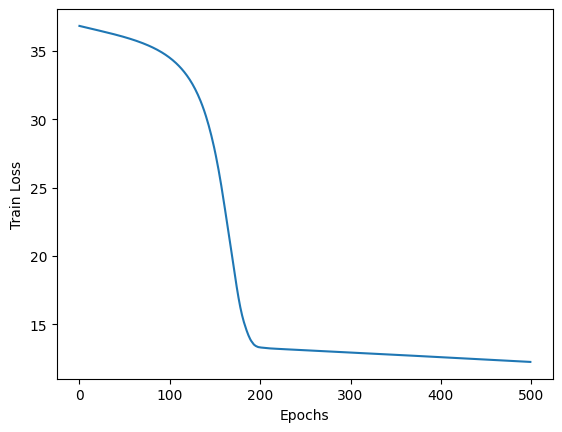

[TEST] MSE Loss: 1430.517994507231 - MAE Loss: 34.273651147737475
loss_mae_lr_0.0001_bs_32.pt
Epoch: 0 - Loss: 36.83709653306768
Epoch: 50 - Loss: 36.44458586101558
Epoch: 100 - Loss: 36.0166836023
Epoch: 150 - Loss: 35.44428255819249
Epoch: 200 - Loss: 34.51125649969389
Epoch: 250 - Loss: 32.61181860724038
Epoch: 300 - Loss: 27.726325877661843
Epoch: 350 - Loss: 17.474379358278398
Epoch: 400 - Loss: 13.3222423479395
Epoch: 450 - Loss: 13.195842336847779
Epoch: 499 - Loss: 13.114714334146656 


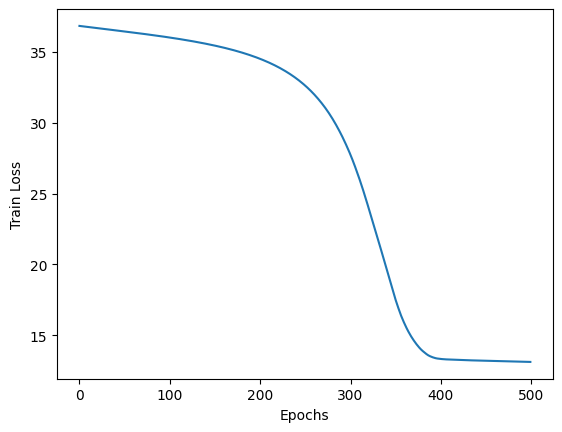

[TEST] MSE Loss: 1431.0687192651446 - MAE Loss: 34.28166404896955
loss_mae_lr_0.0001_bs_64.pt
Epoch: 0 - Loss: 36.83906804374451
Epoch: 50 - Loss: 36.63359318493805
Epoch: 100 - Loss: 36.4292935174315
Epoch: 150 - Loss: 36.214990078824236
Epoch: 200 - Loss: 35.97705429436926
Epoch: 250 - Loss: 35.69790937764965
Epoch: 300 - Loss: 35.35393002492876
Epoch: 350 - Loss: 34.90566211864456
Epoch: 400 - Loss: 34.286037169944564
Epoch: 450 - Loss: 33.375386829349765
Epoch: 499 - Loss: 31.979429528055178 


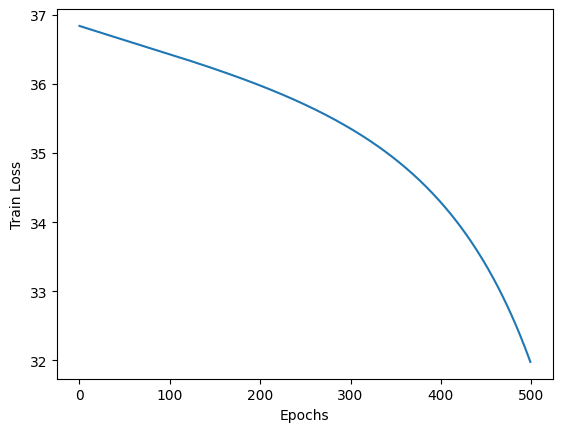

[TEST] MSE Loss: 1431.3325835292778 - MAE Loss: 34.28550393064431


In [ ]:
for loss_type in loss_possible:
    for learning_rate in lr_possible:
        for batch_size in batch_size_possible:
            f_name = 'loss_{}_lr_{}_bs_{}.pt'.format(loss_type, learning_rate, batch_size)
            print(f_name)
            model, criterion, optimizer, n_epochs, device, _, _, dataloader_train, dataloader_test = setup(learning_rate, batch_size, X_train.shape[1], loss_type)
            best_model, train_losses = train(dataloader_train, model, criterion, optimizer, n_epochs, device, f_name)
            plot(train_losses, 'Train Loss')
            mse_loss, mae_loss = test(dataloader_test, best_model, device)
            results_regression_mse[f_name] = mse_loss
            results_regression_mae[f_name] = mae_loss

In [ ]:
results_regression_mse

{'loss_mse_lr_0.01_bs_8.pt': 265.8385728755815,
 'loss_mse_lr_0.01_bs_16.pt': 468.16851293076206,
 'loss_mse_lr_0.01_bs_32.pt': 256.0693616651023,
 'loss_mse_lr_0.01_bs_64.pt': 868.1357978894872,
 'loss_mse_lr_0.001_bs_8.pt': 175.17641713164,
 'loss_mse_lr_0.001_bs_16.pt': 218.1507198988041,
 'loss_mse_lr_0.001_bs_32.pt': 239.945344252108,
 'loss_mse_lr_0.001_bs_64.pt': 648.3202767480153,
 'loss_mse_lr_0.0001_bs_8.pt': 1049.5158126485387,
 'loss_mse_lr_0.0001_bs_16.pt': 1343.1011326860842,
 'loss_mse_lr_0.0001_bs_32.pt': 1392.1120324983565,
 'loss_mse_lr_0.0001_bs_64.pt': 1411.0067004355026,
 'loss_mae_lr_0.01_bs_8.pt': 247.2655927046989,
 'loss_mae_lr_0.01_bs_16.pt': 1281.9611942822107,
 'loss_mae_lr_0.01_bs_32.pt': 1376.4972935154985,
 'loss_mae_lr_0.01_bs_64.pt': 1403.7638061918487,
 'loss_mae_lr_0.001_bs_8.pt': 1410.4350566185021,
 'loss_mae_lr_0.001_bs_16.pt': 1420.8042173910296,
 'loss_mae_lr_0.001_bs_32.pt': 1426.1611276768558,
 'loss_mae_lr_0.001_bs_64.pt': 1428.755751131422,
 

In [ ]:
best_config_mse = sorted(results_regression_mse.items(), key=lambda x: x[1], reverse=False)[0]
configs, loss_mse_min = best_config_mse

In [ ]:
configs

'loss_mse_lr_0.001_bs_8.pt'

In [ ]:
print("[MSE] Least loss: {}, config is with Loss {}, Learning Rate of: {} and Batch Size of: {}".format(loss_mse_min, configs.split('_')[1], configs.split('_')[3], configs.split('_')[5].split('.')[0]))

[MSE] Least loss: 175.17641713164, config is with Loss mse, Learning Rate of: 0.001 and Batch Size of: 8


In [ ]:
results_regression_mae

{'loss_mse_lr_0.01_bs_8.pt': 13.359984712693297,
 'loss_mse_lr_0.01_bs_16.pt': 17.199369955217183,
 'loss_mse_lr_0.01_bs_32.pt': 12.900786464654127,
 'loss_mse_lr_0.01_bs_64.pt': 24.941899475542087,
 'loss_mse_lr_0.001_bs_8.pt': 10.906386881584488,
 'loss_mse_lr_0.001_bs_16.pt': 12.140855468206807,
 'loss_mse_lr_0.001_bs_32.pt': 12.720192412342454,
 'loss_mse_lr_0.001_bs_64.pt': 20.787793211952383,
 'loss_mse_lr_0.0001_bs_8.pt': 28.25336783449241,
 'loss_mse_lr_0.0001_bs_16.pt': 32.97841054181836,
 'loss_mse_lr_0.0001_bs_32.pt': 33.71065991596111,
 'loss_mse_lr_0.0001_bs_64.pt': 33.98877292620711,
 'loss_mae_lr_0.01_bs_8.pt': 12.863503298713166,
 'loss_mae_lr_0.01_bs_16.pt': 32.04037048438606,
 'loss_mae_lr_0.01_bs_32.pt': 33.478704977189835,
 'loss_mae_lr_0.01_bs_64.pt': 33.88223565357789,
 'loss_mae_lr_0.001_bs_8.pt': 33.980236164574485,
 'loss_mae_lr_0.001_bs_16.pt': 34.132029709306735,
 'loss_mae_lr_0.001_bs_32.pt': 34.21019472041948,
 'loss_mae_lr_0.001_bs_64.pt': 34.2480001974260

In [ ]:
best_config_mae = sorted(results_regression_mae.items(), key=lambda x: x[1], reverse=False)[0]
configs, loss_mae_min = best_config_mae

In [ ]:
print("[MAE] Least loss: {}, config is with Loss {}, Learning Rate of: {} and Batch Size of: {}".format(loss_mae_min, configs.split('_')[1], configs.split('_')[3], configs.split('_')[5].split('.')[0]))

[MAE] Least loss: 10.906386881584488, config is with Loss mse, Learning Rate of: 0.001 and Batch Size of: 8


## Question 3 - Medical Image Classification

In [ ]:
# Data preprocessing and loading

# Define a transform to pre-process the image data
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])

# Load the dataset from the directory
data_dir = 'Dataset'  # replace with the path to your dataset.
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create loaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.depth = 16

        self.conv11 = nn.Conv2d(3, self.depth, 3, padding=1, bias=False)
        self.conv12 = nn.Conv2d(self.depth, self.depth, 3, padding=1, bias=False)
        self.batch_norm11 = nn.BatchNorm2d(self.depth)
        self.batch_norm12 = nn.BatchNorm2d(self.depth)

        self.conv21 = nn.Conv2d(self.depth, self.depth*2, 3, padding=1, bias=False)
        self.conv22 = nn.Conv2d(self.depth*2, self.depth*2, 3, padding=1, bias=False)
        self.batch_norm21 = nn.BatchNorm2d(self.depth*2)
        self.batch_norm22 = nn.BatchNorm2d(self.depth*2)

        self.conv31 = nn.Conv2d(self.depth*2, self.depth*4, 3, padding=1, bias=False)
        self.conv32 = nn.Conv2d(self.depth*4, self.depth*4, 3, padding=1, bias=False)
        self.conv33 = nn.Conv2d(self.depth*4, self.depth*4, 3, padding=1, bias=False)
        self.conv34 = nn.Conv2d(self.depth*4, self.depth*4, 3, padding=1, bias=False)
        self.batch_norm31 = nn.BatchNorm2d(self.depth*4)
        self.batch_norm32 = nn.BatchNorm2d(self.depth*4)
        self.batch_norm33 = nn.BatchNorm2d(self.depth*4)
        self.batch_norm34 = nn.BatchNorm2d(self.depth*4)

        self.conv41 = nn.Conv2d(self.depth*4, self.depth*8, 3, padding=1, bias=False)
        self.conv42 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1, bias=False)
        self.conv43 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1, bias=False)
        self.conv44 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1, bias=False)
        self.batch_norm41 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm42 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm43 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm44 = nn.BatchNorm2d(self.depth*8)

        self.conv51 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1)
        self.conv52 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1)
        self.conv53 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1)
        self.conv54 = nn.Conv2d(self.depth*8, self.depth*8, 3, padding=1)
        self.batch_norm51 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm52 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm53 = nn.BatchNorm2d(self.depth*8)
        self.batch_norm54 = nn.BatchNorm2d(self.depth*8)

        self.max_pool = nn.MaxPool2d(2,2)
        self.max_pool_final = nn.MaxPool2d(3,3)
        self.fc1 = nn.Linear(self.depth * 8, self.depth * 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(self.depth * 64, 6)



    def forward(self, x):
        x = F.relu(self.batch_norm11(self.conv11(x)))
        x = F.relu(self.batch_norm12(self.conv12(x)))
        x = self.max_pool(x)

        x = F.relu(self.batch_norm21(self.conv21(x)))
        x = F.relu(self.batch_norm22(self.conv22(x)))
        x = self.max_pool(x)

        x = F.relu(self.batch_norm31(self.conv31(x)))
        x = F.relu(self.batch_norm32(self.conv32(x)))
        x = F.relu(self.batch_norm33(self.conv33(x)))
        x = F.relu(self.batch_norm34(self.conv34(x)))
        x = self.max_pool(x)

        x = F.relu(self.batch_norm41(self.conv41(x)))
        x = F.relu(self.batch_norm42(self.conv42(x)))
        x = F.relu(self.batch_norm43(self.conv43(x)))
        x = F.relu(self.batch_norm44(self.conv44(x)))
        x = self.max_pool(x)

        x = F.relu(self.batch_norm51(self.conv51(x)))
        x = F.relu(self.batch_norm52(self.conv52(x)))
        x = F.relu(self.batch_norm53(self.conv53(x)))
        x = F.relu(self.batch_norm54(self.conv54(x)))

        x = self.max_pool_final(x)
        x = x.view(-1, self.depth*8)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

net = Net()
summary(net, (3, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
            Conv2d-3           [-1, 16, 64, 64]           2,304
       BatchNorm2d-4           [-1, 16, 64, 64]              32
         MaxPool2d-5           [-1, 16, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           4,608
       BatchNorm2d-7           [-1, 32, 32, 32]              64
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
      BatchNorm2d-12           [-1, 64, 16, 16]             128
           Conv2d-13           [-1, 64, 16, 16]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 10

loss_list = []
accuracy_list = []
net.train()
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            average_loss = running_loss / 50
            average_accuracy = 100 * correct_predictions / total_predictions

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {average_loss:.6f}, accuracy: {average_accuracy:.2f}%')

            # Store the loss and accuracy
            loss_list.append(average_loss)
            accuracy_list.append(average_accuracy)

            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

print('Finished Training')

[1,    50] loss: 1.044979, accuracy: 62.31%
[1,   100] loss: 0.145048, accuracy: 95.94%
[2,    50] loss: 0.084643, accuracy: 97.38%
[2,   100] loss: 0.045419, accuracy: 98.62%
[3,    50] loss: 0.023140, accuracy: 99.44%
[3,   100] loss: 0.067263, accuracy: 98.06%
[4,    50] loss: 0.016716, accuracy: 99.62%
[4,   100] loss: 0.015645, accuracy: 99.75%
[5,    50] loss: 0.010589, accuracy: 99.81%
[5,   100] loss: 0.005577, accuracy: 99.94%
[6,    50] loss: 0.006145, accuracy: 99.81%
[6,   100] loss: 0.002157, accuracy: 100.00%
[7,    50] loss: 0.002481, accuracy: 100.00%
[7,   100] loss: 0.003199, accuracy: 99.94%
[8,    50] loss: 0.116392, accuracy: 97.25%
[8,   100] loss: 0.056244, accuracy: 98.56%
[9,    50] loss: 0.009664, accuracy: 99.62%
[9,   100] loss: 0.014588, accuracy: 99.62%
[10,    50] loss: 0.017578, accuracy: 99.56%
[10,   100] loss: 0.007044, accuracy: 99.88%
Finished Training


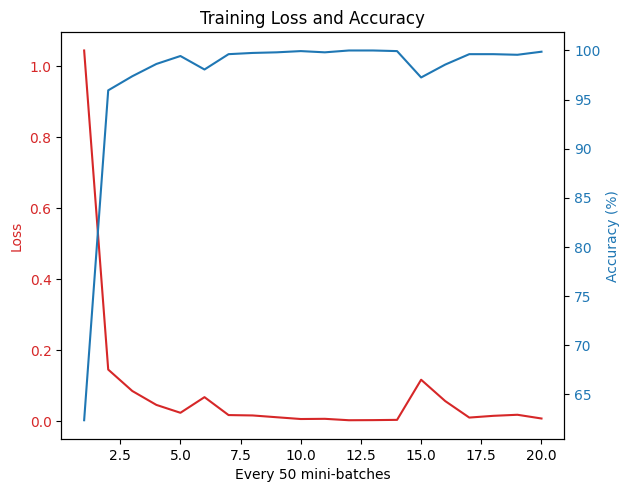

In [ ]:
import matplotlib.pyplot as plt

# Creating the x axis: each point here represents an interval of 50 mini-batches
x_axis = range(1, len(loss_list) + 1)

# Creating subplots: the function subplots() returns a Figure and an Axes object or an array of Axes objects
fig, ax1 = plt.subplots()

# Plotting the loss (left Y-axis)
ax1.set_xlabel('Every 50 mini-batches')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(x_axis, loss_list, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Creating a second Y-axis to plot the accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(x_axis, accuracy_list, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Adding a title to the plot and showing it
fig.tight_layout()
plt.title('Training Loss and Accuracy')
plt.show()

In [ ]:




# Monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

predictions = []
true_labels = []

net.eval()  # Set model to evaluate mode
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        # Forward pass: compute predicted outputs by passing inputs to the model
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = net(inputs)

        # Calculate the loss
        loss = criterion(output, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.6f}\n')
print(f'Test Accuracy: {accuracy:.2f}% ({correct}/{total})\n')

Test Loss: 0.000208

Test Accuracy: 99.67% (1794.0/1800.0)



In [ ]:
class_names = list(dataset.class_to_idx.keys())
report = classification_report(true_labels, predictions, target_names=class_names)

print("Classification Report on Testing Set:")
print(report)

Classification Report on Testing Set:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00       299
   BreastMRI       1.00      0.99      1.00       307
         CXR       1.00      1.00      1.00       307
     ChestCT       1.00      1.00      1.00       281
        Hand       1.00      0.99      0.99       284
      HeadCT       0.98      1.00      0.99       322

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

